# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
import itertools
import pickle
from matplotlib import pyplot as plt
import datetime
from scipy import optimize
import sys
sys.path.append('../SEIR_full/')
sys.path.append('..')
import SEIR_full as mdl
import datetime as dt
from scipy.stats import poisson
from scipy.stats import binom
import copy

In [2]:
plt.style.use('dean_style.conf')

In [3]:
isr_pop = 9136000

# Model run

In [4]:

model = mdl.Model_behave(
    beta_j=np.array([0.02927922 ,0.02927922 ,0.02927922 ,0.04655266,0.04655266,0.05775265,0.05775265,0.18444245,0.18444245]),
    theta=2.826729434860104,
    beta_behave=0.5552998605894367,
    eps=mdl.eps_sector['Scenario2'],
    f=mdl.f0_full['Scenario2'],
)

res_mdl = model.predict(
    C=mdl.C_calibration,
    days_in_season=200,
    stay_home_idx=mdl.stay_home_idx,
    not_routine=mdl.not_routine,
)

model.reset()

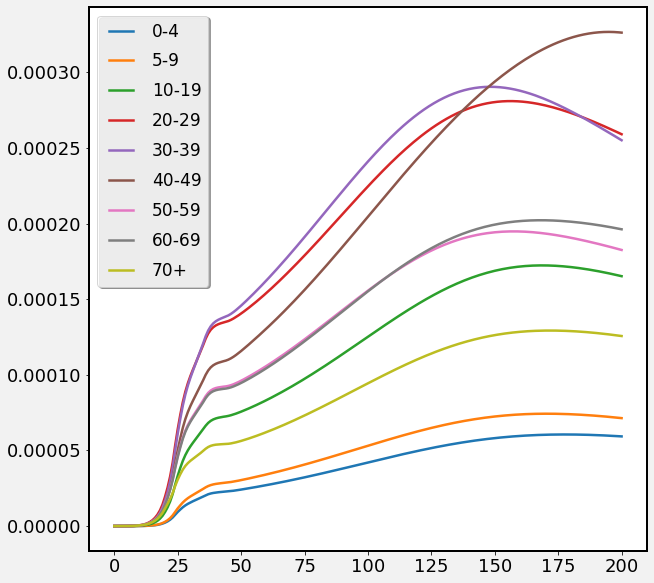

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28ee126f0c8>)

In [5]:
mdl.plot_I_by_age(res_mdl)

# Model Calibration

In [90]:
first = pd.Timestamp('2020-03-03')
last = pd.Timestamp('2020-04-18')

## Data

In [7]:
tot = pd.read_csv('../Data/sick/all_tests_by_age_county.csv')
pos = pd.read_csv('../Data/sick/smooth_sick_by_age_county.csv')

In [8]:
# Preparing data for fit:
tot.drop('age_unknown', axis=1, inplace=True)
tot.set_index('test_date', inplace=True)
tot.columns = ['county'] + list(mdl.A.values())
tot.sort_values(by='county', inplace=True)
tot = tot.pivot(columns='county')
tot.columns = tot.columns.swaplevel(0, 1)
tot = tot.reindex(pd.MultiIndex.from_product([mdl.G.values(), mdl.A.values()]), axis=1)
tot.index = pd.to_datetime(tot.index)
tot = tot.reindex(pd.date_range(tot.index.values.min(), tot.index.values.max(),freq='d'), fill_value=0)
tot.fillna(0, inplace=True)

pos.drop('age_unknown', axis=1, inplace=True)
pos.set_index('Unnamed: 1', inplace=True)
pos.columns = ['county'] + list(mdl.A.values())
pos.sort_values(by='county', inplace=True)
pos = pos.pivot(columns='county')
pos.columns = pos.columns.swaplevel(0, 1)
pos = pos.reindex(pd.MultiIndex.from_product([mdl.G.values(), mdl.A.values()]), axis=1)
pos.index = pd.to_datetime(pos.index)
pos = pos.reindex(pd.date_range(pos.index.values.min(), pos.index.values.max(),freq='d'), fill_value=0)
pos.fillna(0, inplace=True)

begining = min([pos.index.values.min(), tot.index.values.min()])
ending = max([pos.index.values.max(), tot.index.values.max()])
pos = pos.reindex(pd.date_range(begining, ending,freq='d'), fill_value=0)
tot = tot.reindex(pd.date_range(begining, ending,freq='d'), fill_value=0)

In [11]:
# Shifting data by 6 days for fit
pos_0303 = pos.loc['2020-03-03':].copy() #starting the fit from March 3rd 2020

shift_date_list = pd.date_range('2020-02-26',freq='d',periods=pos_0303.shape[0])

pos_0303['shift_date'] = shift_date_list

In [12]:
pos_0303.set_index('shift_date',inplace=True)

In [13]:
data = np.ndarray((2,len(pos_0303), len(mdl.GA.values())))
data[0] = tot[:pos_0303.shape[0]] # insert the tested positive specimens only for relevant calibration period 
data[1] = pos_0303

# Fit model Matan

## Scenario 2

In [91]:
# fit params
days_in_season=70
date_lst = pd.date_range('2020-02-20',last)
len(date_lst)

59

In [15]:
# Model Fitting
p0=(0.0981001,0.05305112,0.05157651,0.3,2.103427546494595, 0.23785134529029744) # initial guess
bnds = ((0,0.1),(0,0.15),(0,0.15),(0,0.4),(1.5,3),(0,0.6))# boundries for variables


In [17]:
model.reset()
model.update({'sigma':1./4.4, 'nu':0.1})

In [20]:
res_fit = model.fit(
        p0=p0,
        bnds=bnds,
        data=data,
        date_lst = date_lst,
        days_in_season=days_in_season,
        start='2020-02-26',
        end='2020-04-09',
        loss_func='MSE',
        maxiter=300,
        factor=1,
    )

iter:  50  loss:  -25.286651523683272
iter:  100  loss:  -25.28666225695731
iter:  150  loss:  -25.28666842165207
iter:  200  loss:  -25.28664352824454
iter:  250  loss:  -25.286668634525913
iter:  300  loss:  -25.28667188969636
iter:  350  loss:  -25.28667337954782
iter:  400  loss:  -25.286675707520644
iter:  450  loss:  -25.286307312819737
iter:  500  loss:  -25.28667897564827
iter:  550  loss:  -25.286670456114894
iter:  600  loss:  -25.258880990145563
iter:  650  loss:  -25.286679827472604
iter:  700  loss:  -25.28128182902487
iter:  750  loss:  -25.28668093344763
iter:  800  loss:  -25.28380934191835
iter:  850  loss:  -25.286681325314152
iter:  900  loss:  -25.286681551047835
iter:  950  loss:  -25.28668348428066
iter:  1000  loss:  -25.286684542087375
iter:  1050  loss:  -25.28668697644248
iter:  1100  loss:  -25.28668778459287
iter:  1150  loss:  -25.286680448438474
iter:  1200  loss:  -25.284386681612624
iter:  1250  loss:  -25.28668802414523
iter:  1300  loss:  -25.286688259

In [21]:
mdl.print_stat_fit_behave(res_fit)

minimized value: -25.28668836556765
Fitted parameters:
 Beta=[0.09883986 0.05334751 0.05144386 0.30902021]
 Theta=2.074502181457254,
 Beta_behave=0.2364975456730552
num of sampling the target function: 176


In [94]:
model.reset()
model.update({'nu':1/15.})
res_mdl = model.predict(
    C=mdl.C_calibration,
    days_in_season=200,
    stay_home_idx=mdl.stay_home_idx,
    not_routine=mdl.not_routine,
)

In [95]:
model.beta_j

array([0.09883986, 0.09883986, 0.09883986, 0.05334751, 0.05334751,
       0.05144386, 0.05144386, 0.30902021, 0.30902021])

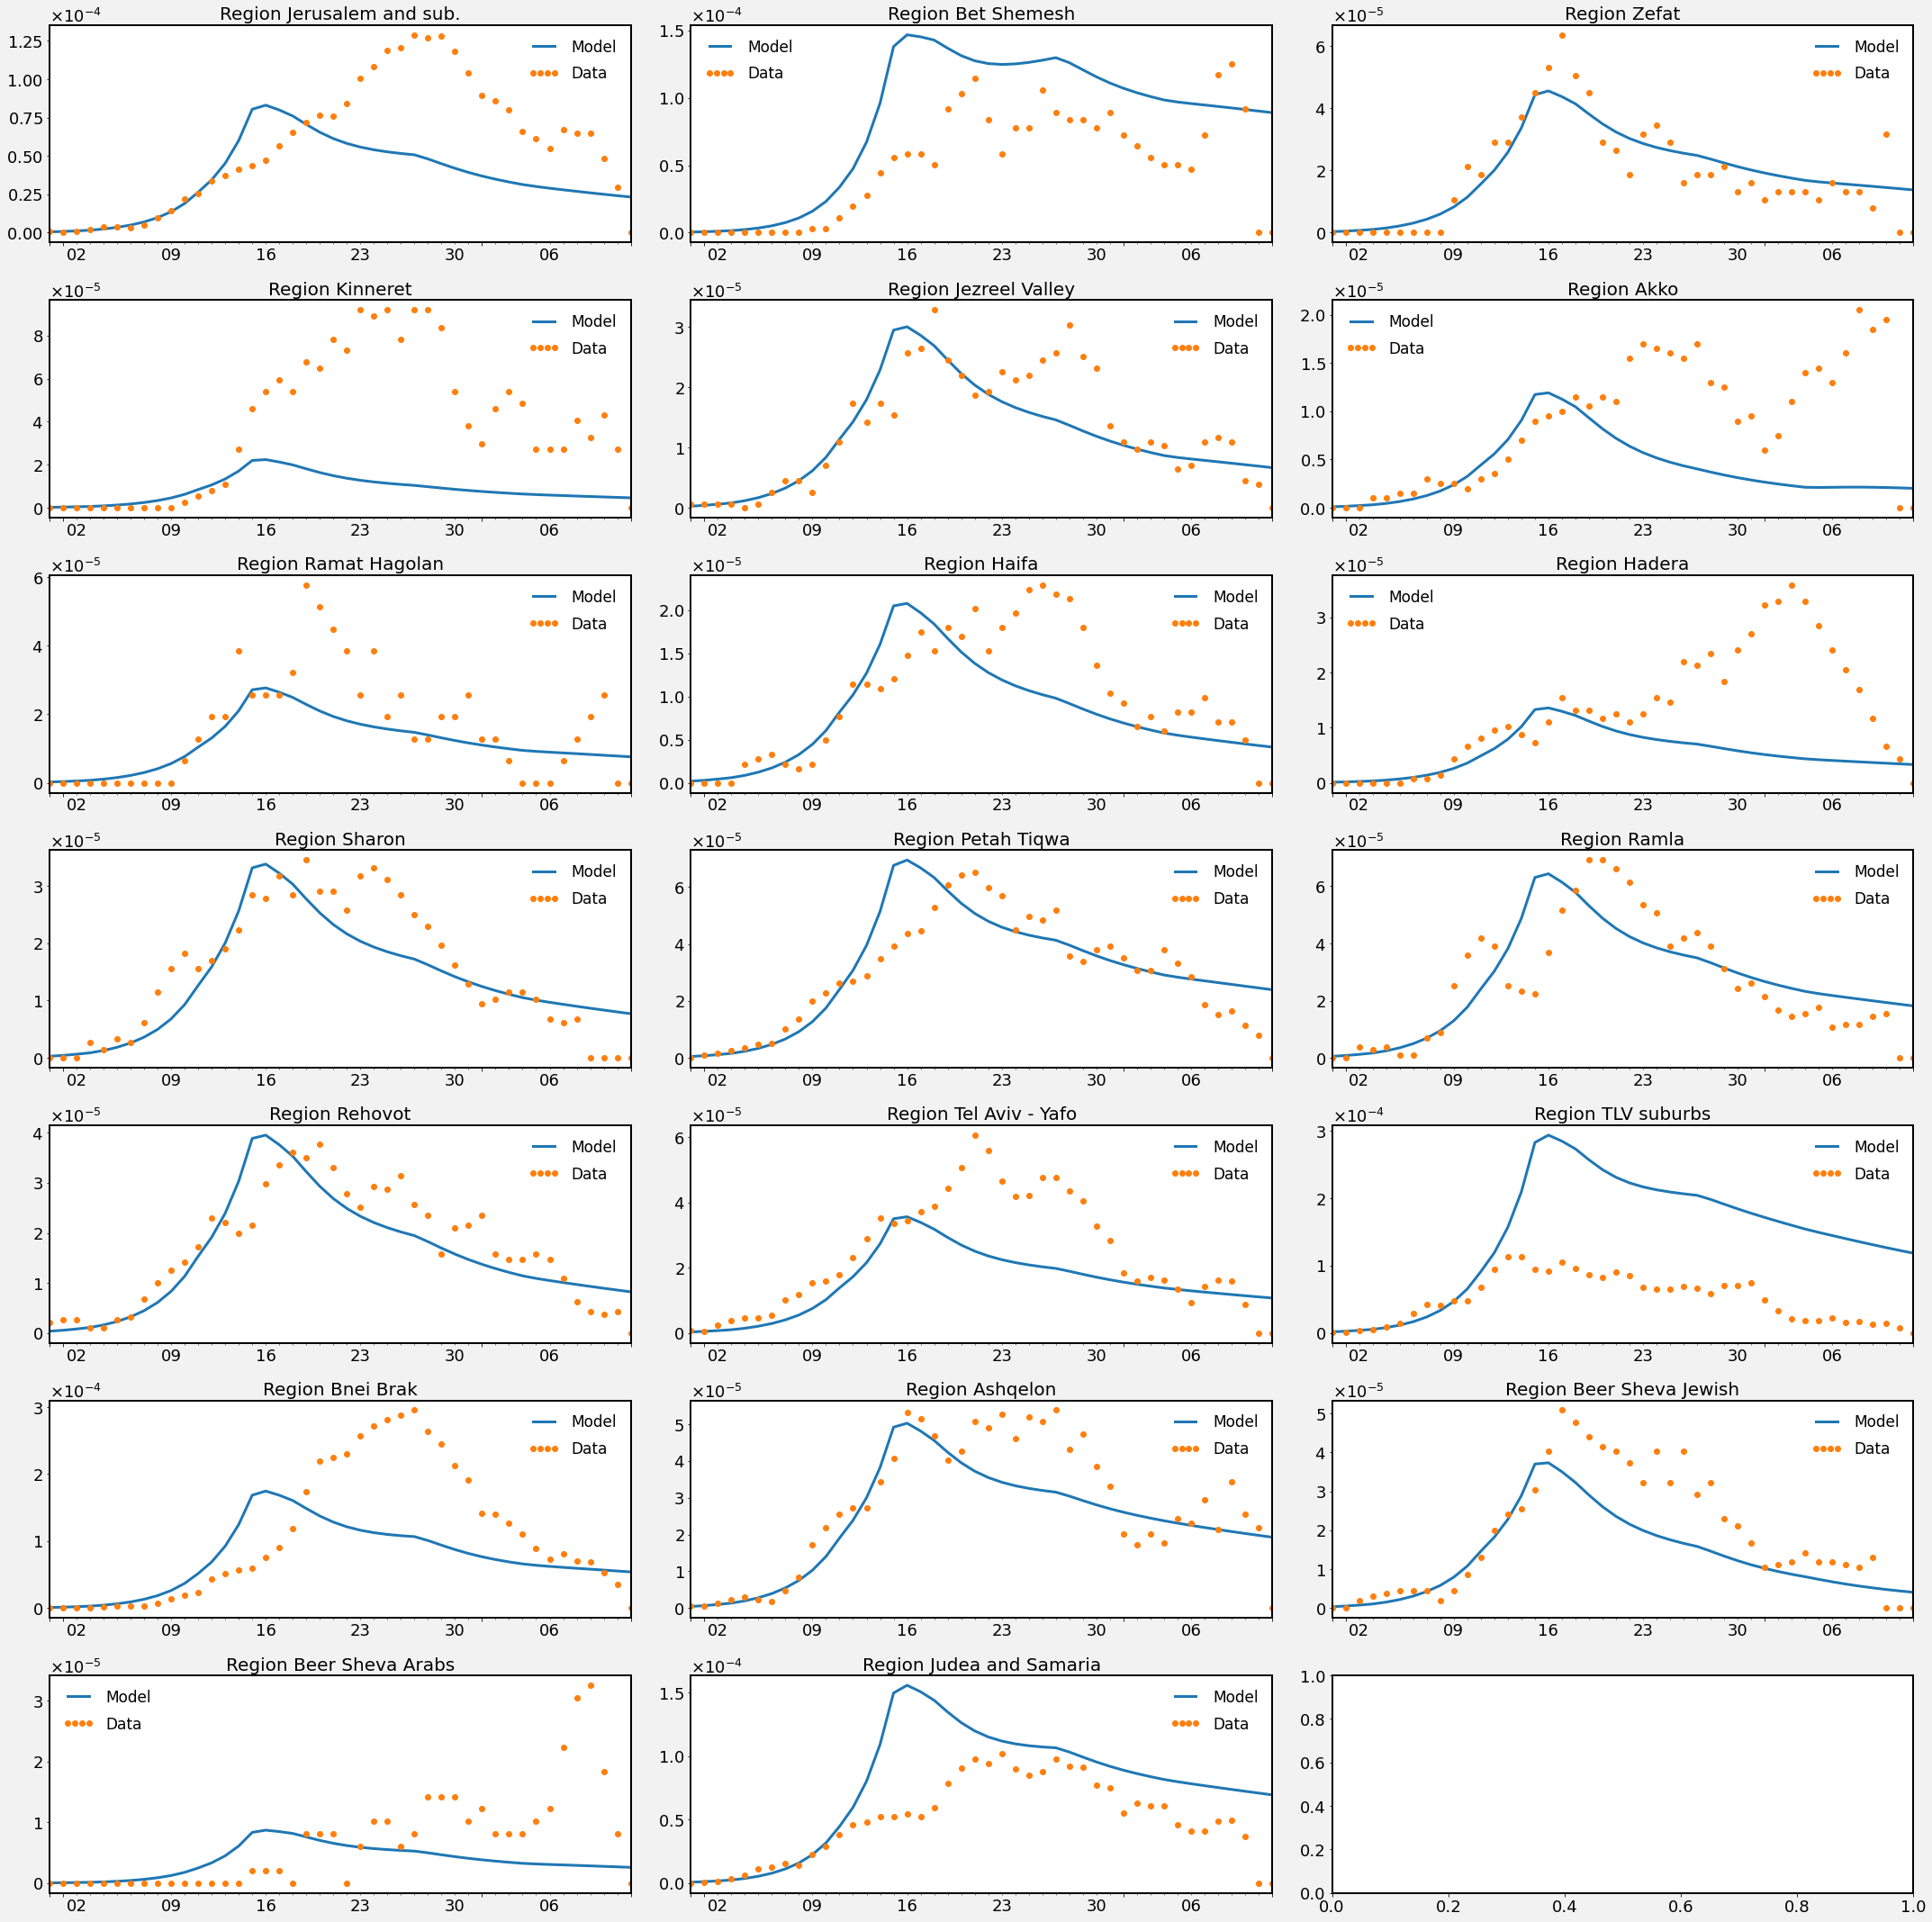

In [24]:
# plotting the data and model
fig,ax = mdl.plot_calibrated_model_region(data=data, 
                                          mdl_data = res_mdl['new_Is'],
                                          date_list = date_lst,
                                          start='2020-02-29',
                                          end='2020-04-12',
                                          region_name = mdl.cell,
                                          loss_func = 'MSE')
fig.set_size_inches((30,30))
plt.tight_layout()
plt.show()

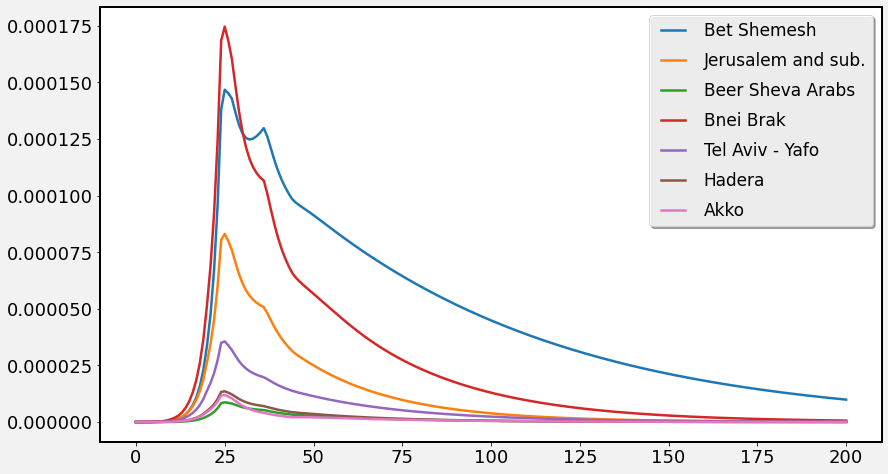

In [25]:
# Creating table 1, by region:
tabel_1_dict = {}
for region in ['11_betshemesh','11','62_arab','51_bb','51','32','24']:
    tabel_1_dict[mdl.cell[region]] = (res_mdl['new_Is'][:, mdl.region_dict[region]].sum(axis=1))/mdl.population_size[mdl.region_dict[region]].sum()
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

tabel1_df.iloc[:].plot()

In [26]:
(res_mdl['new_Is']).sum()

0.001912198900378699

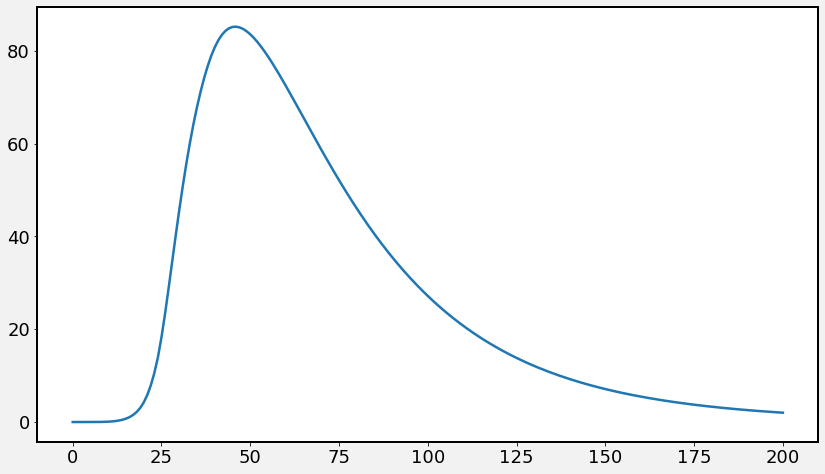

In [96]:
plt.plot(res_mdl['H'].sum(axis=1)*9136000)

In [85]:
date_lst[-1]

Timestamp('2020-04-13 00:00:00', freq='D')

(<Figure size 1008x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28eea880dc8>)

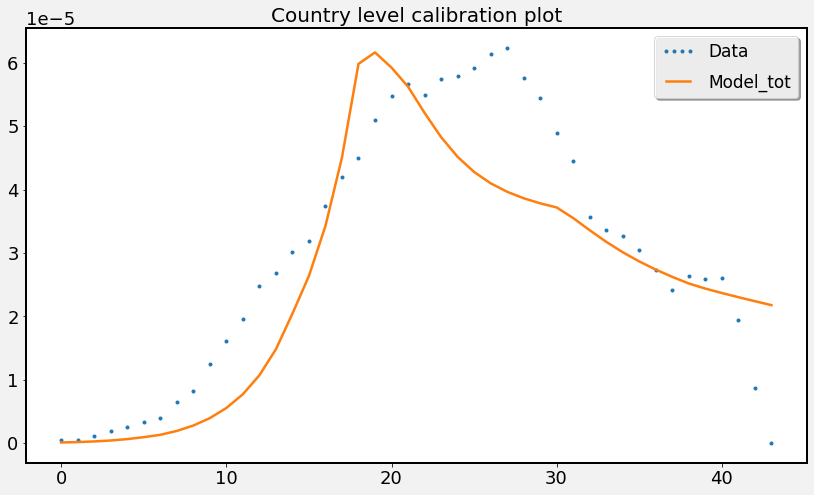

In [29]:
mdl.plot_calibrated_total_model(pd.DataFrame(data[1])/9136000,res_mdl,date_lst,start='2020-02-26',end='2020-04-09')

## Model Variance

In [30]:
model_start_idx = int(np.where(date_lst == '2020-02-26')[0])
model_end_idx = int(np.where(date_lst == '2020-04-09')[0])

In [31]:
# Calculation of variance:
# model results array based on region and age:
model_by_age_region = {}
for i, key in enumerate(mdl.region_age_dict.keys()):
    model_by_age_region[key[0] + '_' + key[1] + '_mdl'] = res_mdl['new_Is'][model_start_idx:model_end_idx+1, mdl.region_age_dict[key]].sum(axis=1)
model_by_age_region = pd.DataFrame.from_dict(model_by_age_region)

In [32]:
model_std = (np.sqrt((np.power((data[1]/isr_pop - model_by_age_region.values),2).sum())/data[1].size))

In [127]:
model_std

2.4067397786831007e-07

## Fit UB for different CIs

======checking CI 90.0%=======
iter:  50  loss:  -24.759038483894752
iter:  100  loss:  -24.765145205138687
iter:  150  loss:  -24.781214883130353
iter:  200  loss:  -24.68037895714571
iter:  250  loss:  -24.796518980154662
iter:  300  loss:  -24.761659873631764
iter:  350  loss:  -24.77960540808225
iter:  400  loss:  -24.797415186941794
iter:  450  loss:  -24.801032928702472
iter:  500  loss:  -24.802926111100476
iter:  550  loss:  -24.79388396805358
iter:  600  loss:  -24.80306407693242
iter:  650  loss:  -24.802639218212253
iter:  700  loss:  -24.80314460475881
iter:  750  loss:  -24.803186897553346
iter:  800  loss:  -24.803187823608226
iter:  850  loss:  -24.80318721366874
iter:  900  loss:  -24.803189024649374
iter:  950  loss:  -24.803189290289854
minimized value: -24.803189290290465
Fitted parameters:
 Beta=[0.1157294  0.06716495 0.07727618 0.41851232]
 Theta=1.5,
 Beta_behave=0.23409992936184507
num of sampling the target function: 118


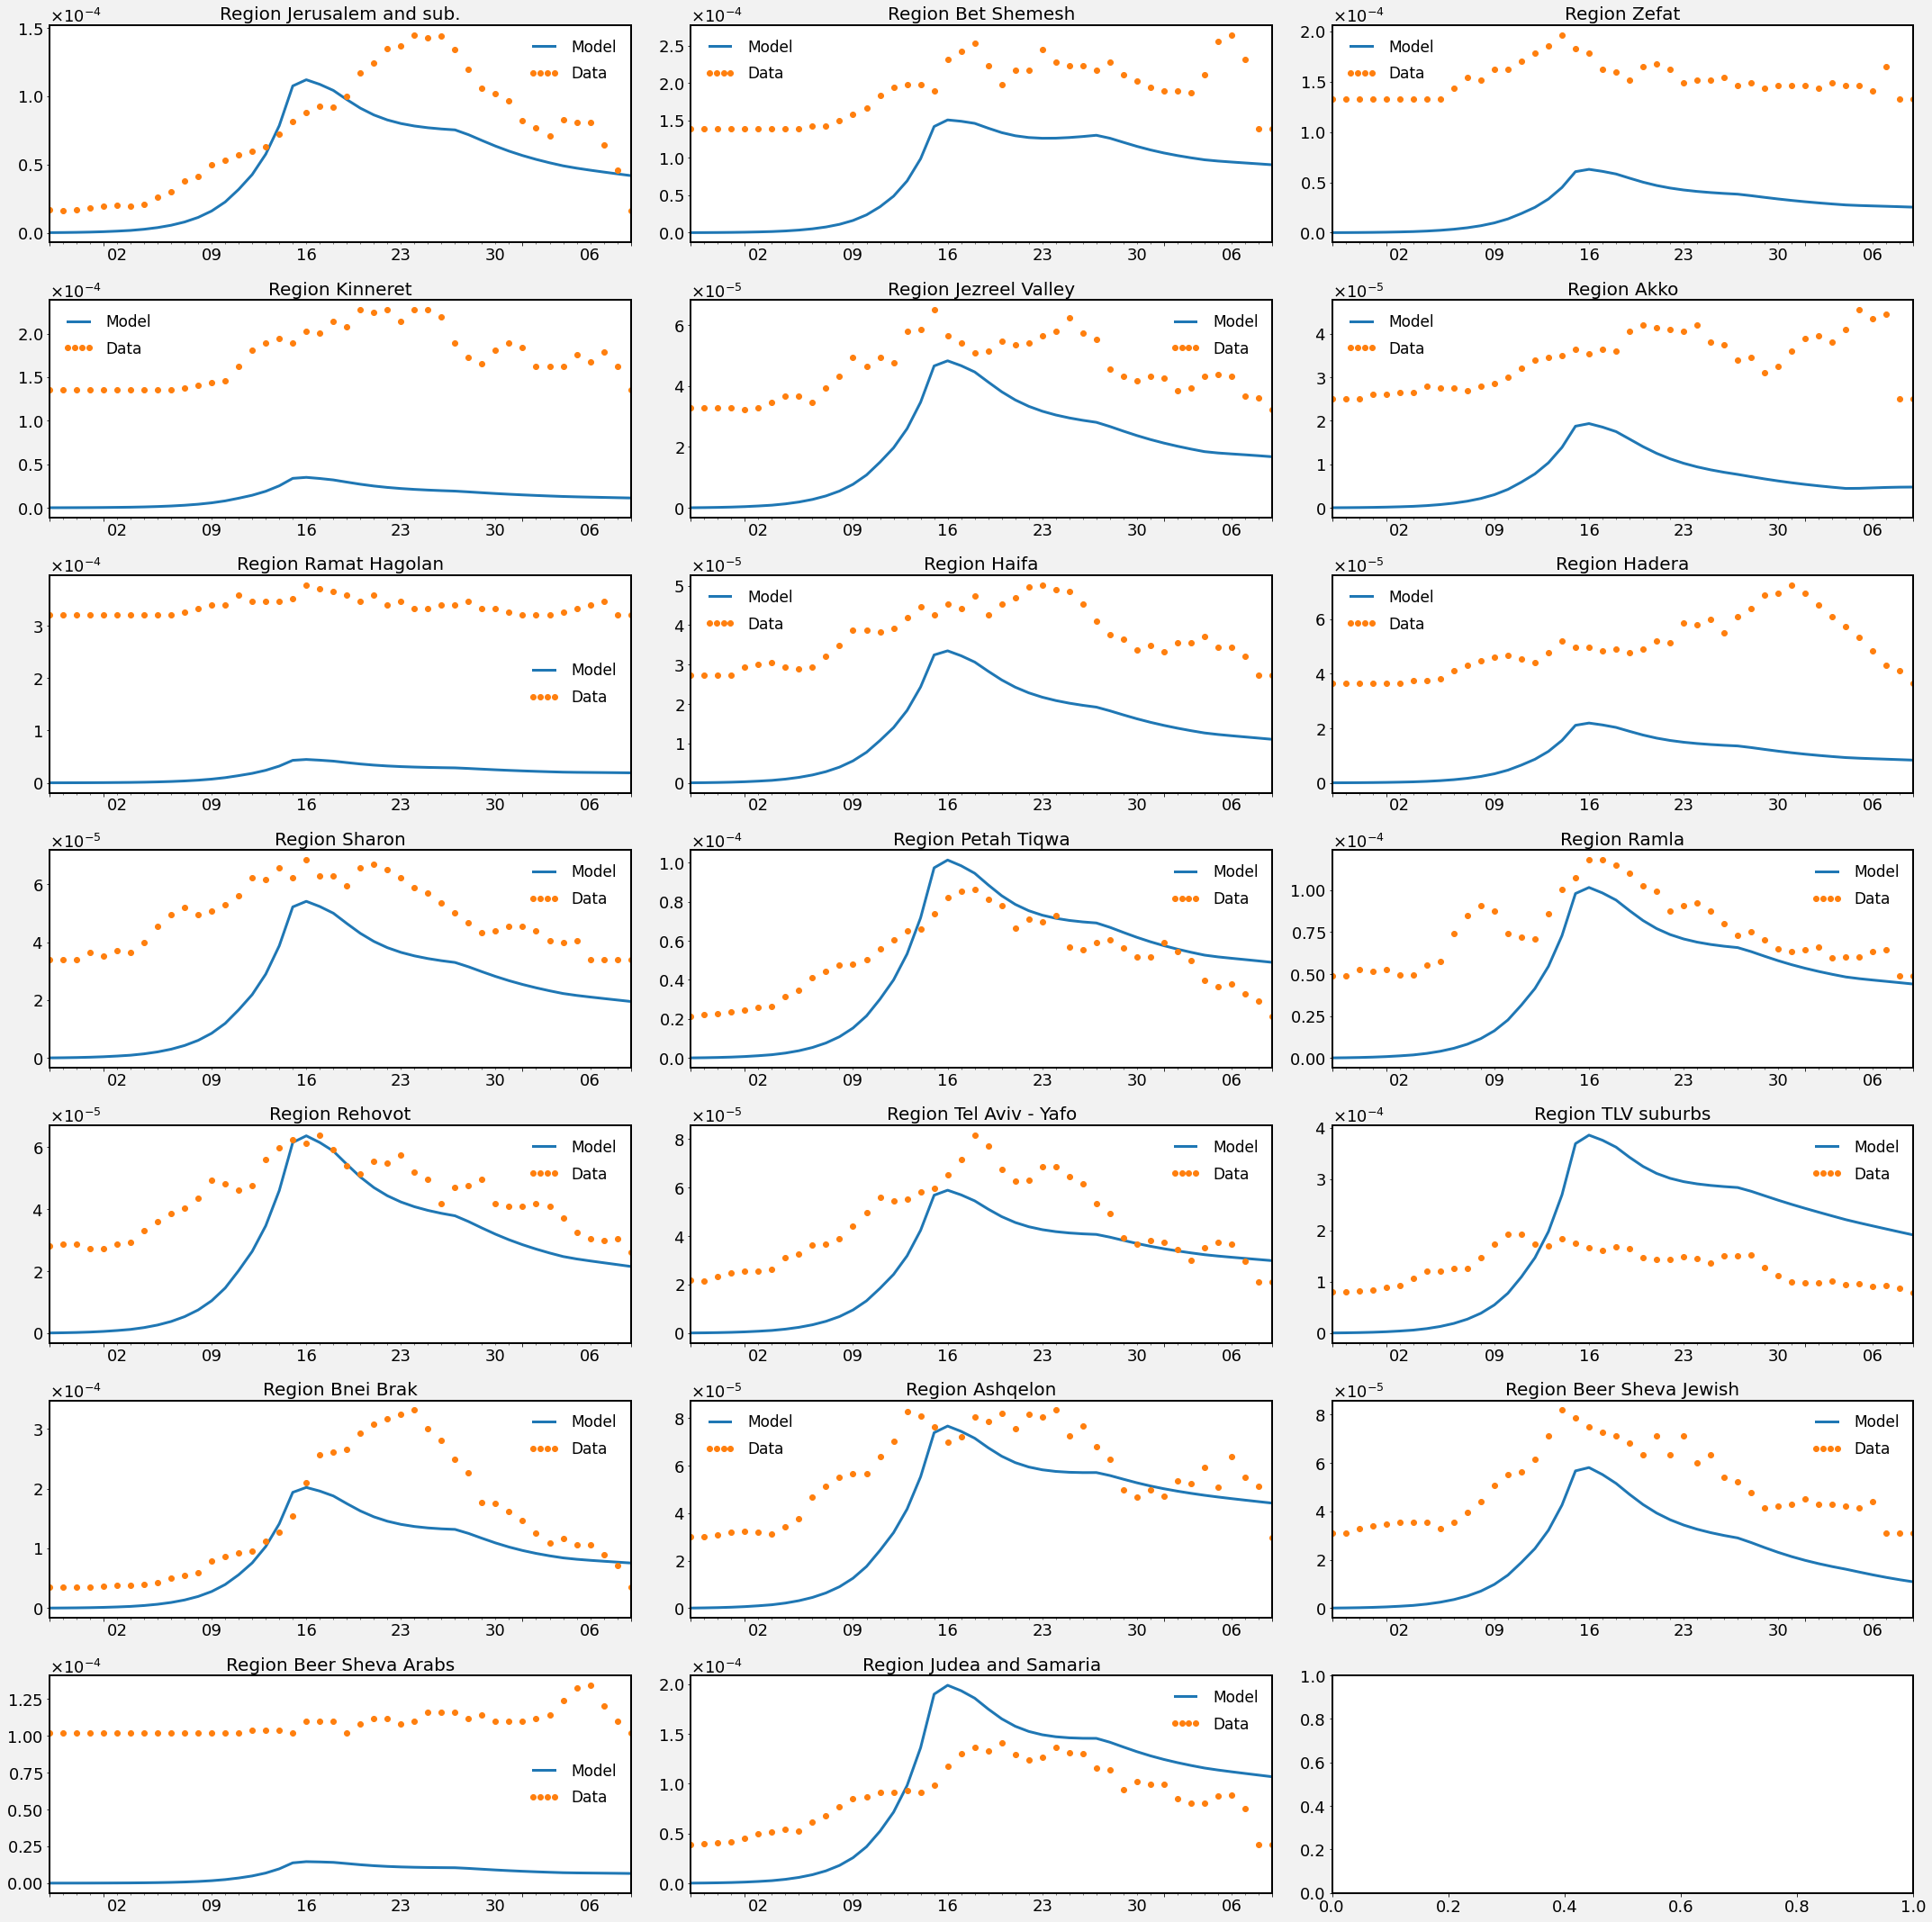

======checking CI 87.5%=======
iter:  50  loss:  -24.88894877671723
iter:  100  loss:  -24.906323147824462
iter:  150  loss:  -24.907933184416343
iter:  200  loss:  -24.909165350663482
iter:  250  loss:  -24.910849532269207
iter:  300  loss:  -24.913076963520698
iter:  350  loss:  -24.914901194473376
iter:  400  loss:  -24.918644740987563
iter:  450  loss:  -24.921535916082966
iter:  500  loss:  -24.921783349657822
iter:  550  loss:  -24.925872043736298
iter:  600  loss:  -24.926475052749204
iter:  650  loss:  -24.71278278721245
iter:  700  loss:  -24.9290074401845
iter:  750  loss:  -24.929965589003096
iter:  800  loss:  -24.521778901849558
iter:  850  loss:  -24.930010467564518
iter:  900  loss:  -24.931199566032355
iter:  950  loss:  -24.820626142497453
iter:  1000  loss:  -24.931197768656745
iter:  1050  loss:  -24.93122251718597
iter:  1100  loss:  -24.931241111436364
iter:  1150  loss:  -24.931265091590475
iter:  1200  loss:  -24.9314268896519
iter:  1250  loss:  -24.931562342460

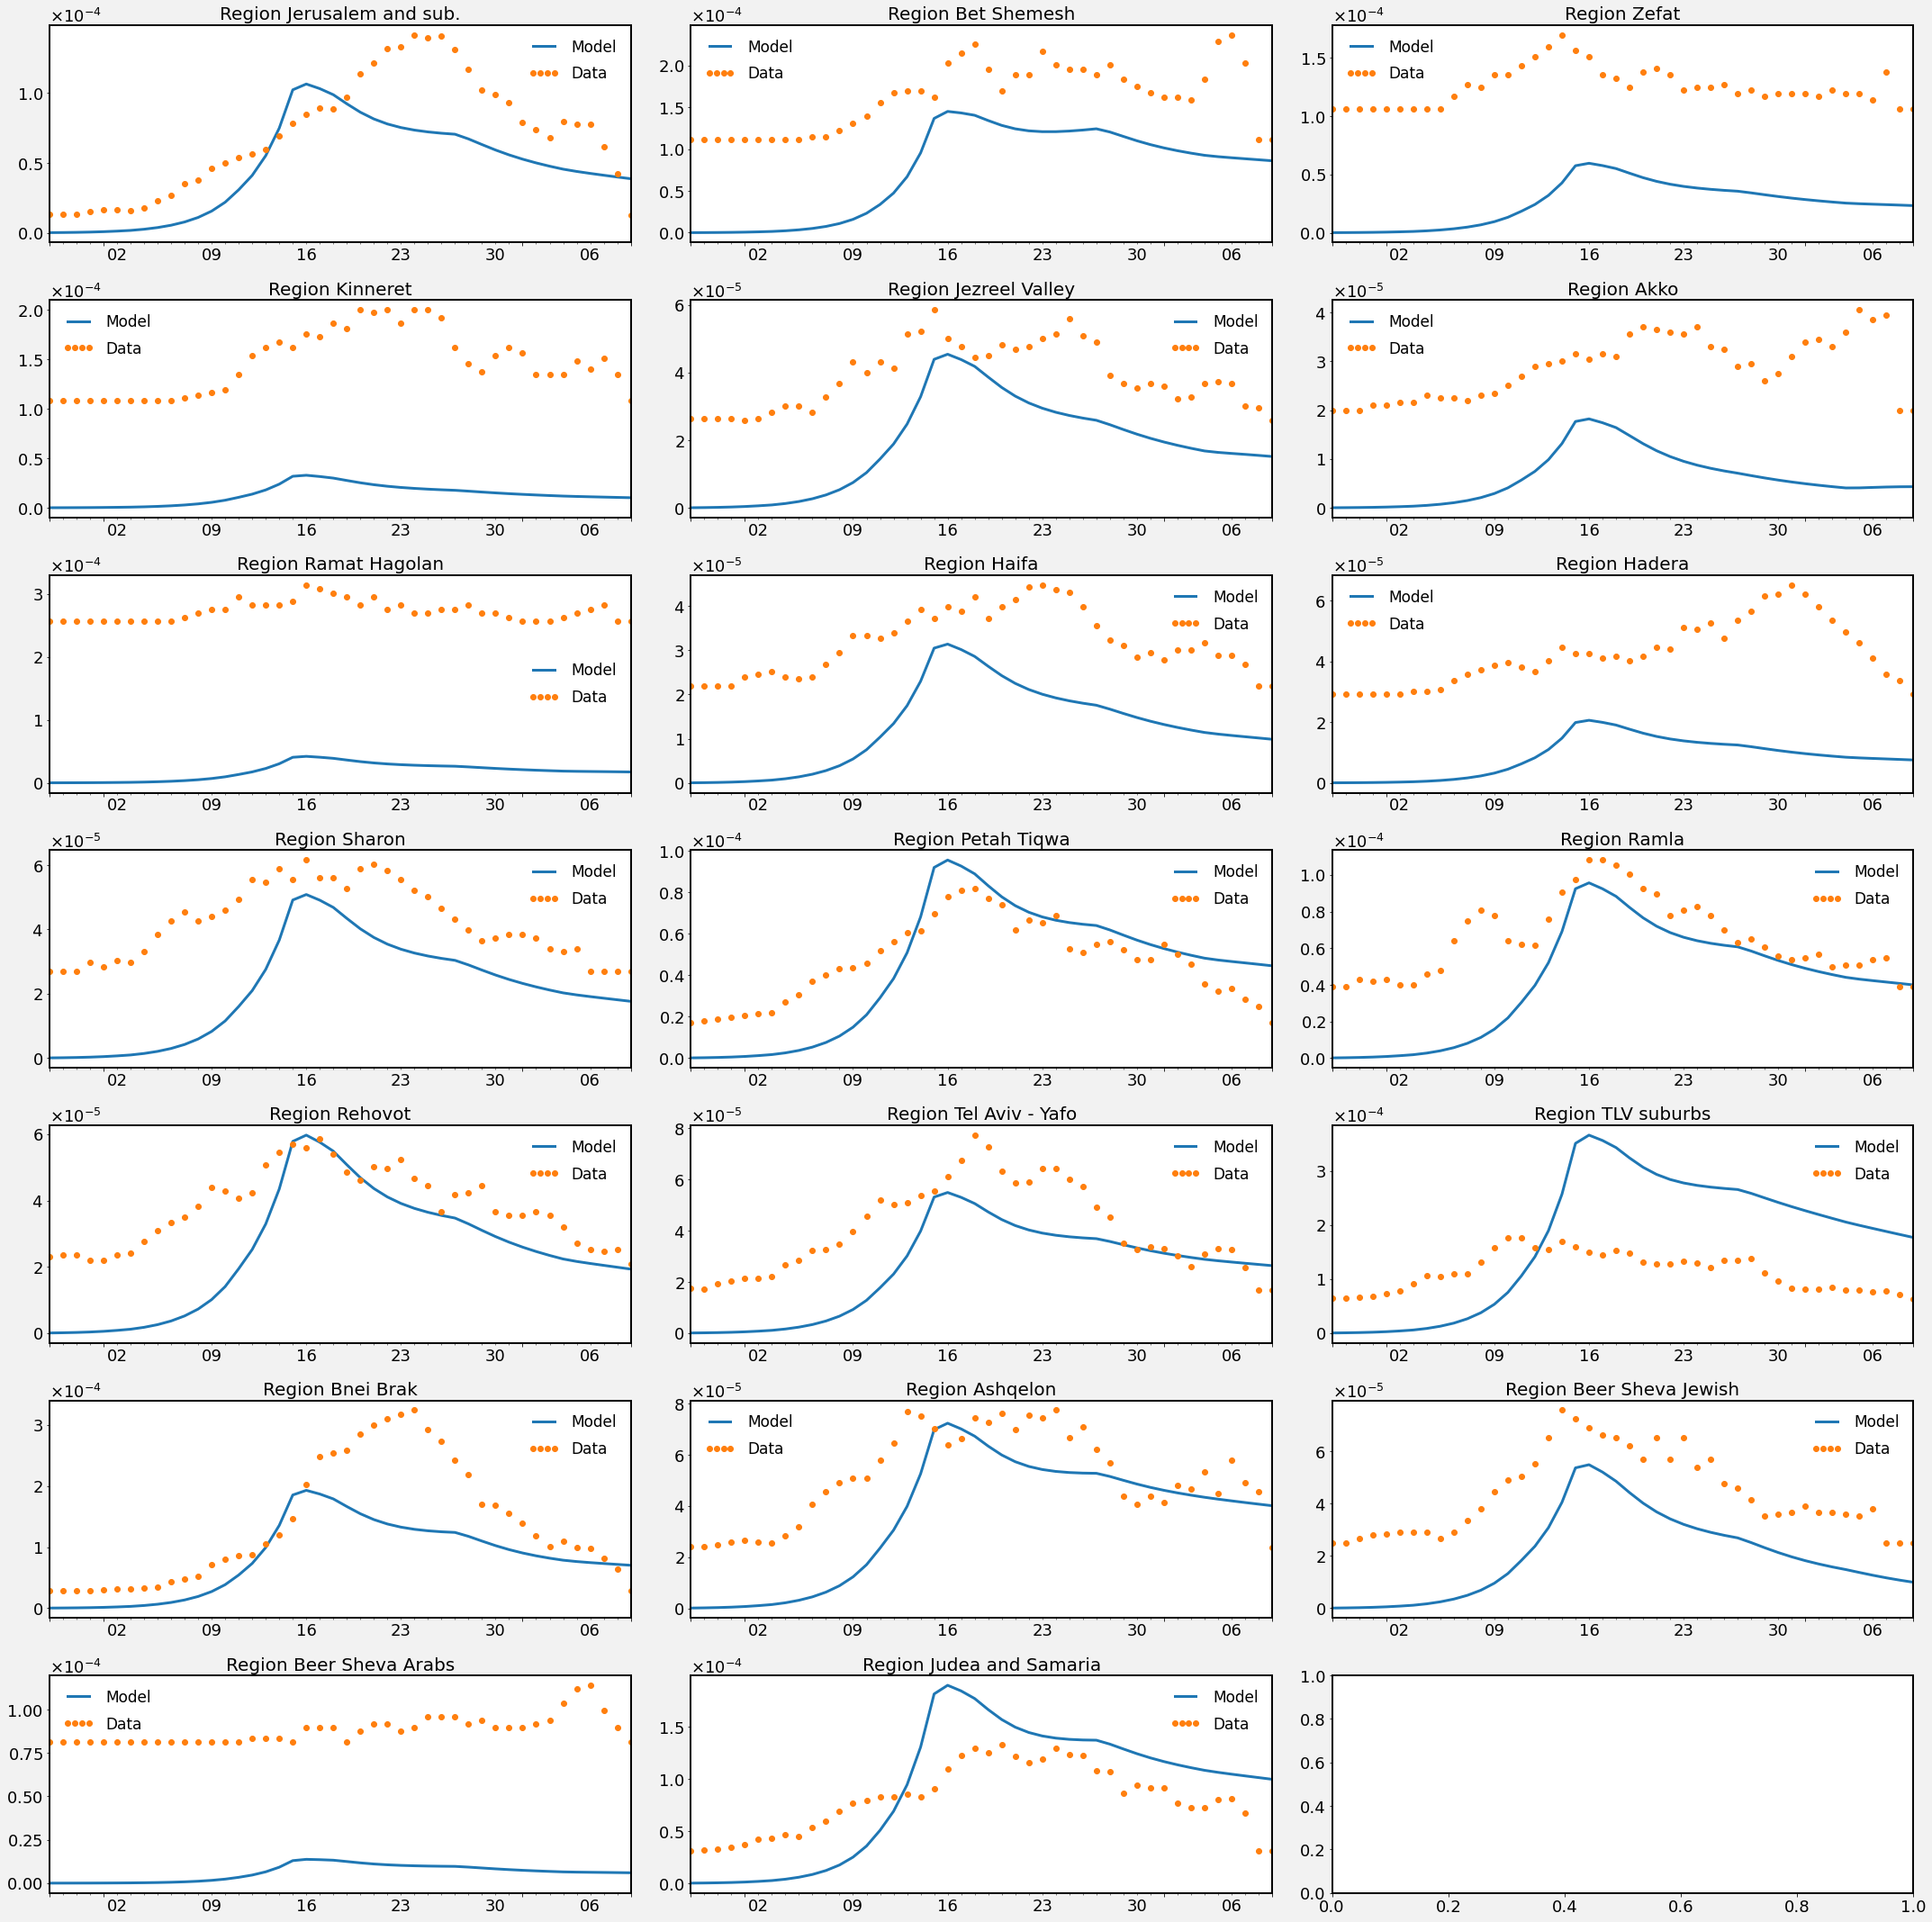

======checking CI 85.0%=======
iter:  50  loss:  -25.011617833326248
iter:  100  loss:  -25.024237689787753
iter:  150  loss:  -25.026960738725663
iter:  200  loss:  -25.0277171292371
iter:  250  loss:  -25.027128339356377
iter:  300  loss:  -25.02852424371825
iter:  350  loss:  -25.028846118644854
iter:  400  loss:  -25.028891336139754
iter:  450  loss:  -25.029459439470212
iter:  500  loss:  -25.029734374892996
iter:  550  loss:  -25.030424462436134
iter:  600  loss:  -25.035136348309532
iter:  650  loss:  -25.03726312341383
iter:  700  loss:  -25.037716819756625
iter:  750  loss:  -25.037967988718684
iter:  800  loss:  -25.03885236890102
iter:  850  loss:  -25.041132198949875
iter:  900  loss:  -25.04144344335839
iter:  950  loss:  -25.041598113539568
iter:  1000  loss:  -25.041771800114184
iter:  1050  loss:  -25.041824100317505
iter:  1100  loss:  -25.041820579944826
iter:  1150  loss:  -25.04183104130905
iter:  1200  loss:  -25.04183564304977
minimized value: -25.041835781765347


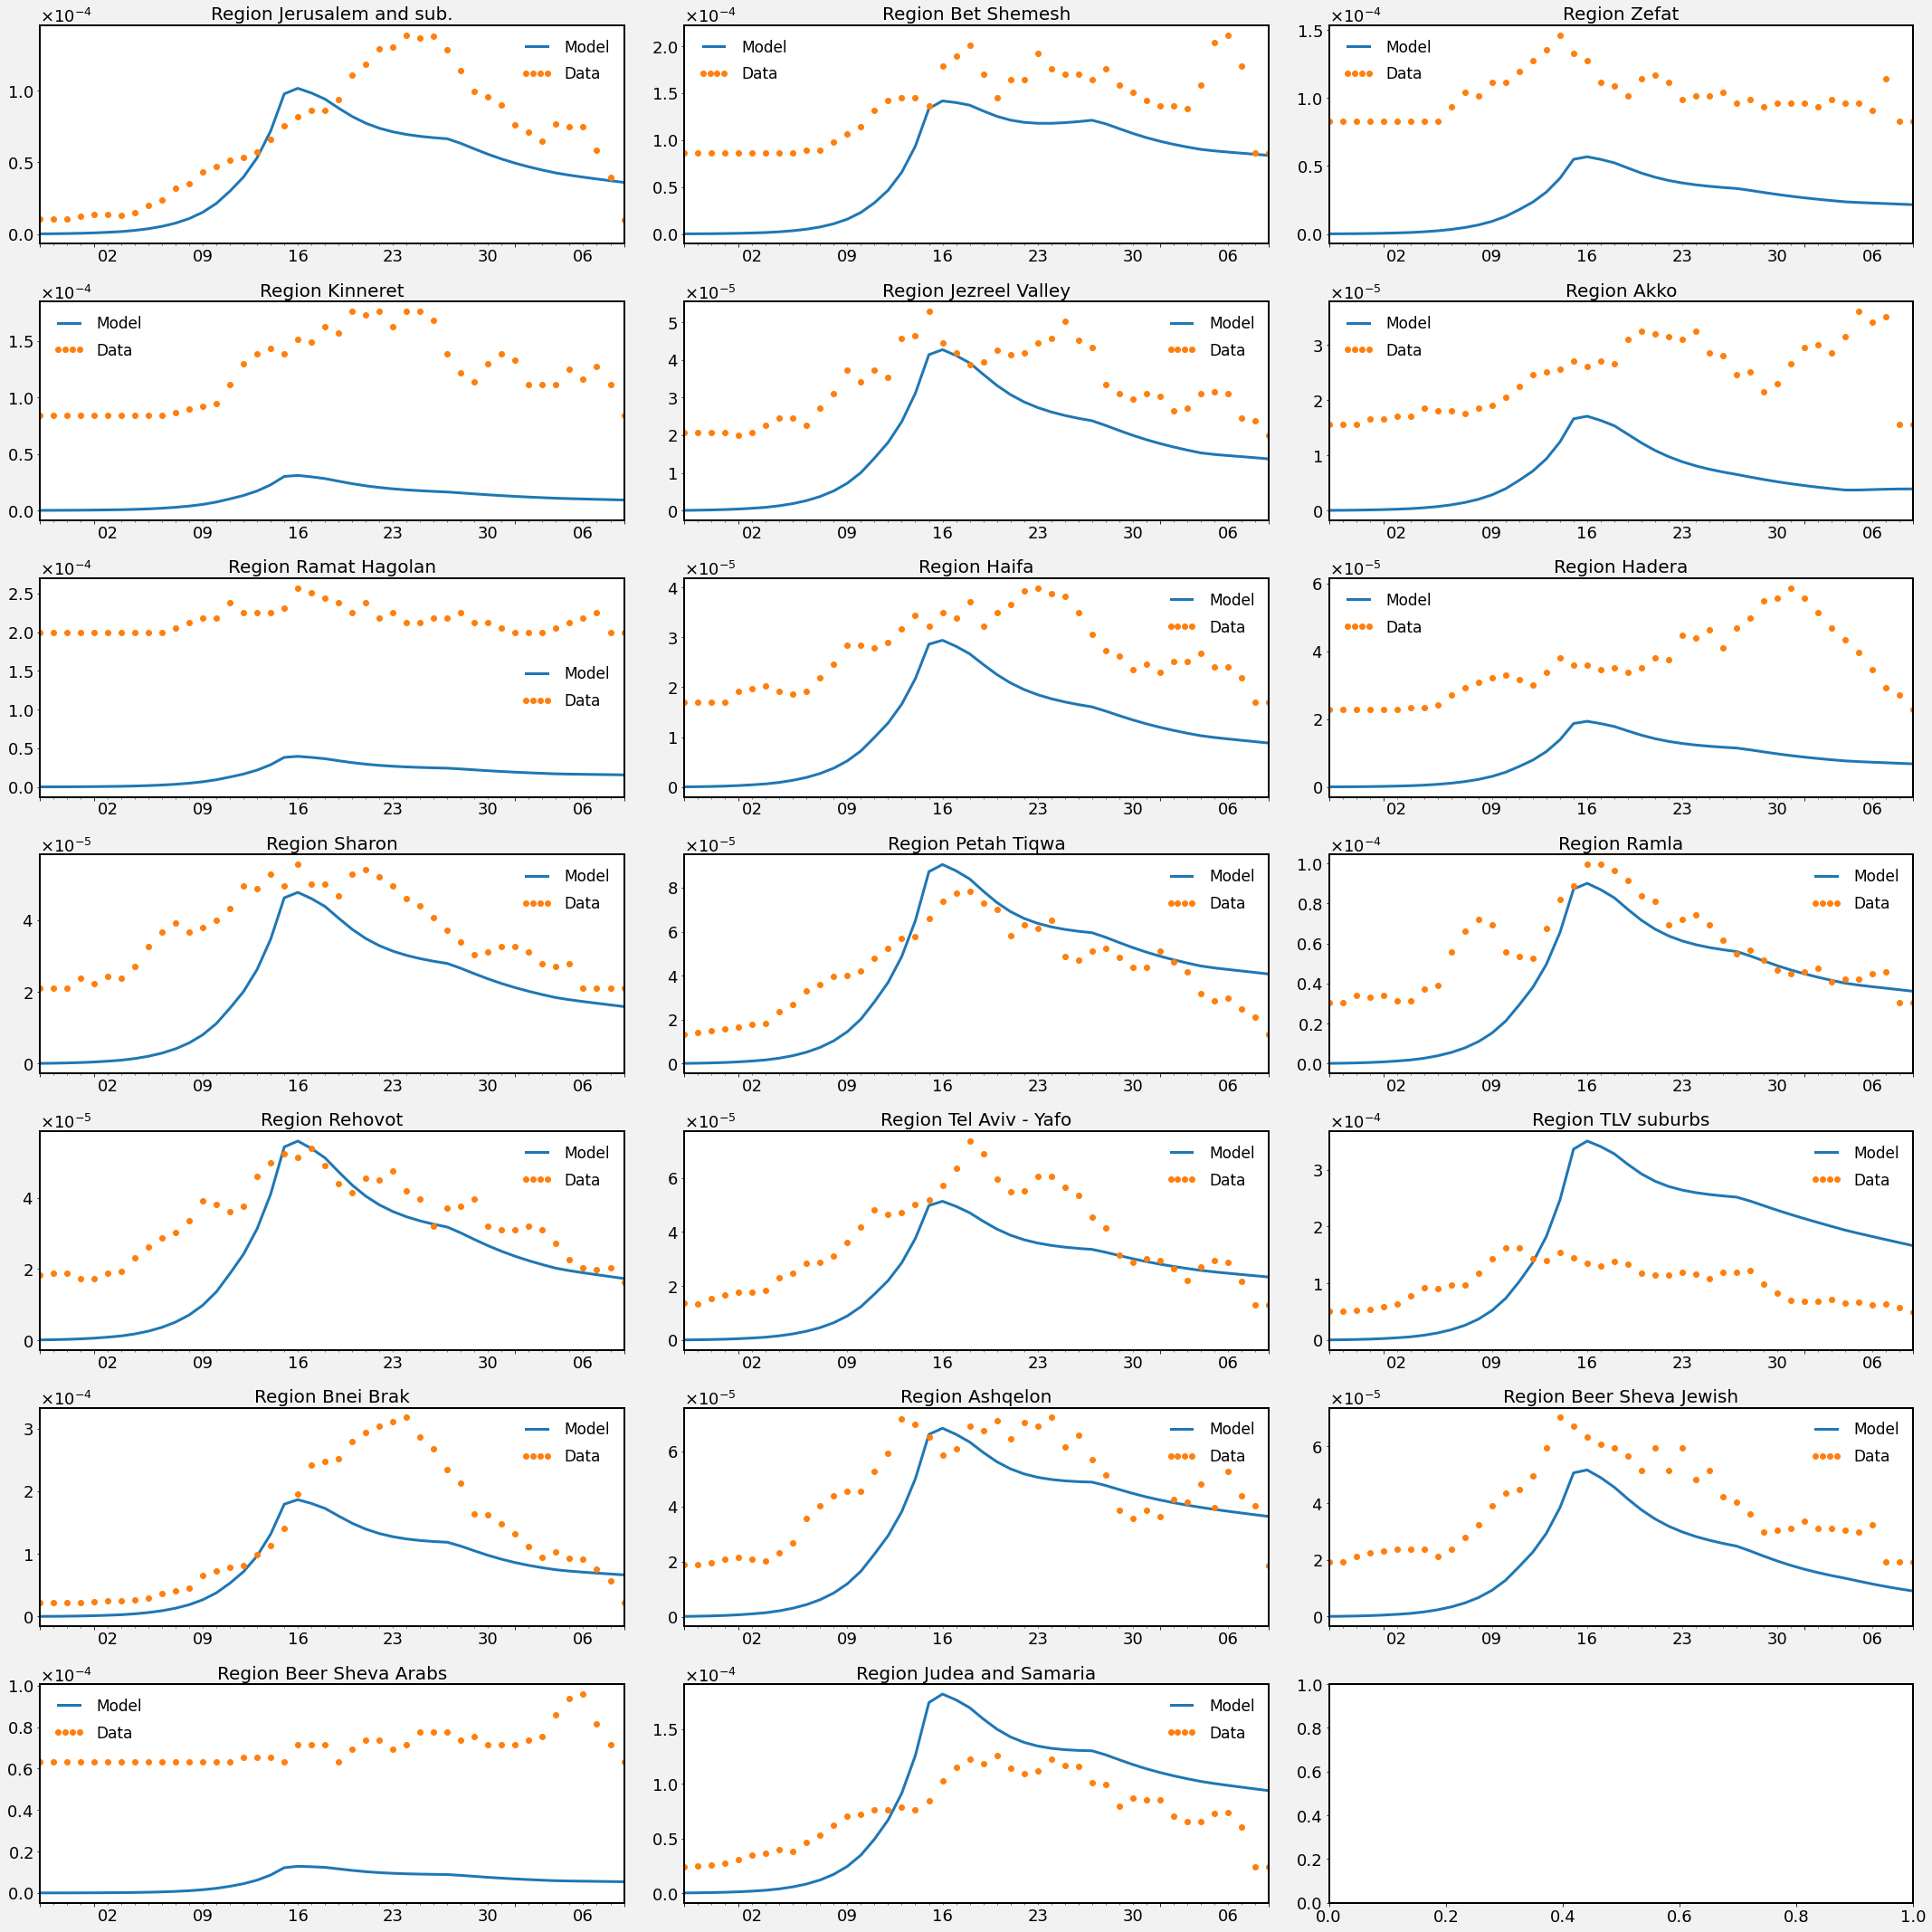

In [138]:
all_calibrations = {}
for percent,z in [('80%',0.842), ('75%',0.674), ('70%',0.524)]:
    res_model = {}
    print('======checking CI {}%======='.format(100 - (100-float(percent[:-1]))/2))
    # calculate new data:
    new_data = data.copy()
    new_data[1] = ((data[1]/isr_pop) + z*model_std)*isr_pop
    
    # initializing model:
    curr_mdl = mdl.Model_behave(
    beta_j=np.array([0.02927922 ,0.02927922 ,0.02927922 ,0.04655266,0.04655266,0.05775265,0.05775265,0.18444245,0.18444245]),
    theta=2.826729434860104,
    beta_behave=0.5552998605894367,
    eps=mdl.eps_sector['Scenario2'],
    f=mdl.f0_full['Scenario2'],
    sigma=1/4.4,
    nu=0.1
    )
#      Model Fitting
    days_in_season=70
    p0=(0.0981001,0.05305112,0.05157651,0.3,2.103427546494595, 0.23785134529029744) # initial guess
    bnds = ((0,0.15),(0,0.15),(0,0.15),(0,0.54),(1.5,3),(0,0.7))# boundries for variables
    
    res_fit_curr = curr_mdl.fit(
        p0=p0,
        bnds=bnds,
        data=new_data,
        date_lst = date_lst,
        days_in_season=days_in_season,
        start='2020-02-26',
        end='2020-04-09',
        loss_func='MSE',
        maxiter=300,
        factor=1,
    )
    mdl.print_stat_fit_behave(res_fit_curr)
    
    curr_mdl.reset()
    res_mdl_curr = curr_mdl.predict(
        C=mdl.C_calibration,
        days_in_season=200,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )
        
        # plotting the data and model
    fig,ax = mdl.plot_calibrated_model_region(data=new_data, 
                                              mdl_data = res_mdl_curr['new_Is'],
                                              date_list = date_lst,
                                              start='2020-02-26',
                                              end='2020-04-09',
                                              region_name = mdl.cell,
                                              loss_func = 'MSE')
    fig.set_size_inches((30,30))
    plt.tight_layout()
    plt.show()
    
    all_calibrations[percent] = {'beta_j':curr_mdl.beta_j, 'beta_behave':curr_mdl.beta_behave, 'theta':curr_mdl.theta}
    
    

In [139]:
# Save calibrated params
with open('calibrattion_dict.pickle', 'wb') as handle:
    pickle.dump(all_calibrations, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Fit UB

In [33]:
# UB data:
data_ub = data.copy()
data_ub[1] = ((data[1]/isr_pop) + 1.96*model_std)*isr_pop

In [52]:
model_ub = mdl.Model_behave(
    beta_j=np.array([0.02927922 ,0.02927922 ,0.02927922 ,0.04655266,0.04655266,0.05775265,0.05775265,0.18444245,0.18444245]),
    theta=2.826729434860104,
    beta_behave=0.5552998605894367,
    eps=mdl.eps_sector['Scenario2'],
    f=mdl.f0_full['Scenario2'],
    sigma=1/4.4,
    nu=0.1
)

In [55]:
# Model Fitting
days_in_season=70
p0=(0.0981001,0.05305112,0.05157651,0.3,2.103427546494595, 0.23785134529029744) # initial guess
bnds = ((0,0.15),(0,0.15),(0,0.15),(0,0.54),(1.5,3),(0,0.7))# boundries for variables

In [56]:
res_fit_ub = model_ub.fit(
        p0=p0,
        bnds=bnds,
        data=data_ub,
        date_lst = date_lst,
        days_in_season=days_in_season,
        start='2020-02-26',
        end='2020-04-09',
        loss_func='MSE',
        maxiter=300,
        factor=1,
    )

iter:  50  loss:  -23.793345006101166
iter:  100  loss:  -23.86128625082176
iter:  150  loss:  -23.768825783679986
iter:  200  loss:  -23.88384295629578
iter:  250  loss:  -23.886894936283092
iter:  300  loss:  -23.907348717584682
iter:  350  loss:  -23.907833587727158
iter:  400  loss:  -23.909010010332608
iter:  450  loss:  -23.89580259747962
iter:  500  loss:  -23.91205589824108
iter:  550  loss:  -23.912890593031143
iter:  600  loss:  -23.912891241032373
iter:  650  loss:  -23.91289801421874
iter:  700  loss:  -23.91287388603845
iter:  750  loss:  -23.91290333038493
iter:  800  loss:  -23.912905636562158
iter:  850  loss:  -23.913014375138143
iter:  900  loss:  -23.91315943154877
iter:  950  loss:  -23.9131852399209
iter:  1000  loss:  -23.91341588456315
iter:  1050  loss:  -23.91055015605241
iter:  1100  loss:  -23.913447224459752
iter:  1150  loss:  -23.91349153729363
iter:  1200  loss:  -23.913874193355788
iter:  1250  loss:  -23.91293506585285
iter:  1300  loss:  -23.9141791686

In [57]:
mdl.print_stat_fit_behave(res_fit_ub)

minimized value: -23.91582570963037
Fitted parameters:
 Beta=[0.12501922 0.07354475 0.09657314 0.48909651]
 Theta=1.5,
 Beta_behave=0.2280608311545828
num of sampling the target function: 218


In [58]:
model_ub.reset()
res_mdl_ub = model_ub.predict(
    C=mdl.C_calibration,
    days_in_season=200,
    stay_home_idx=mdl.stay_home_idx,
    not_routine=mdl.not_routine,
)

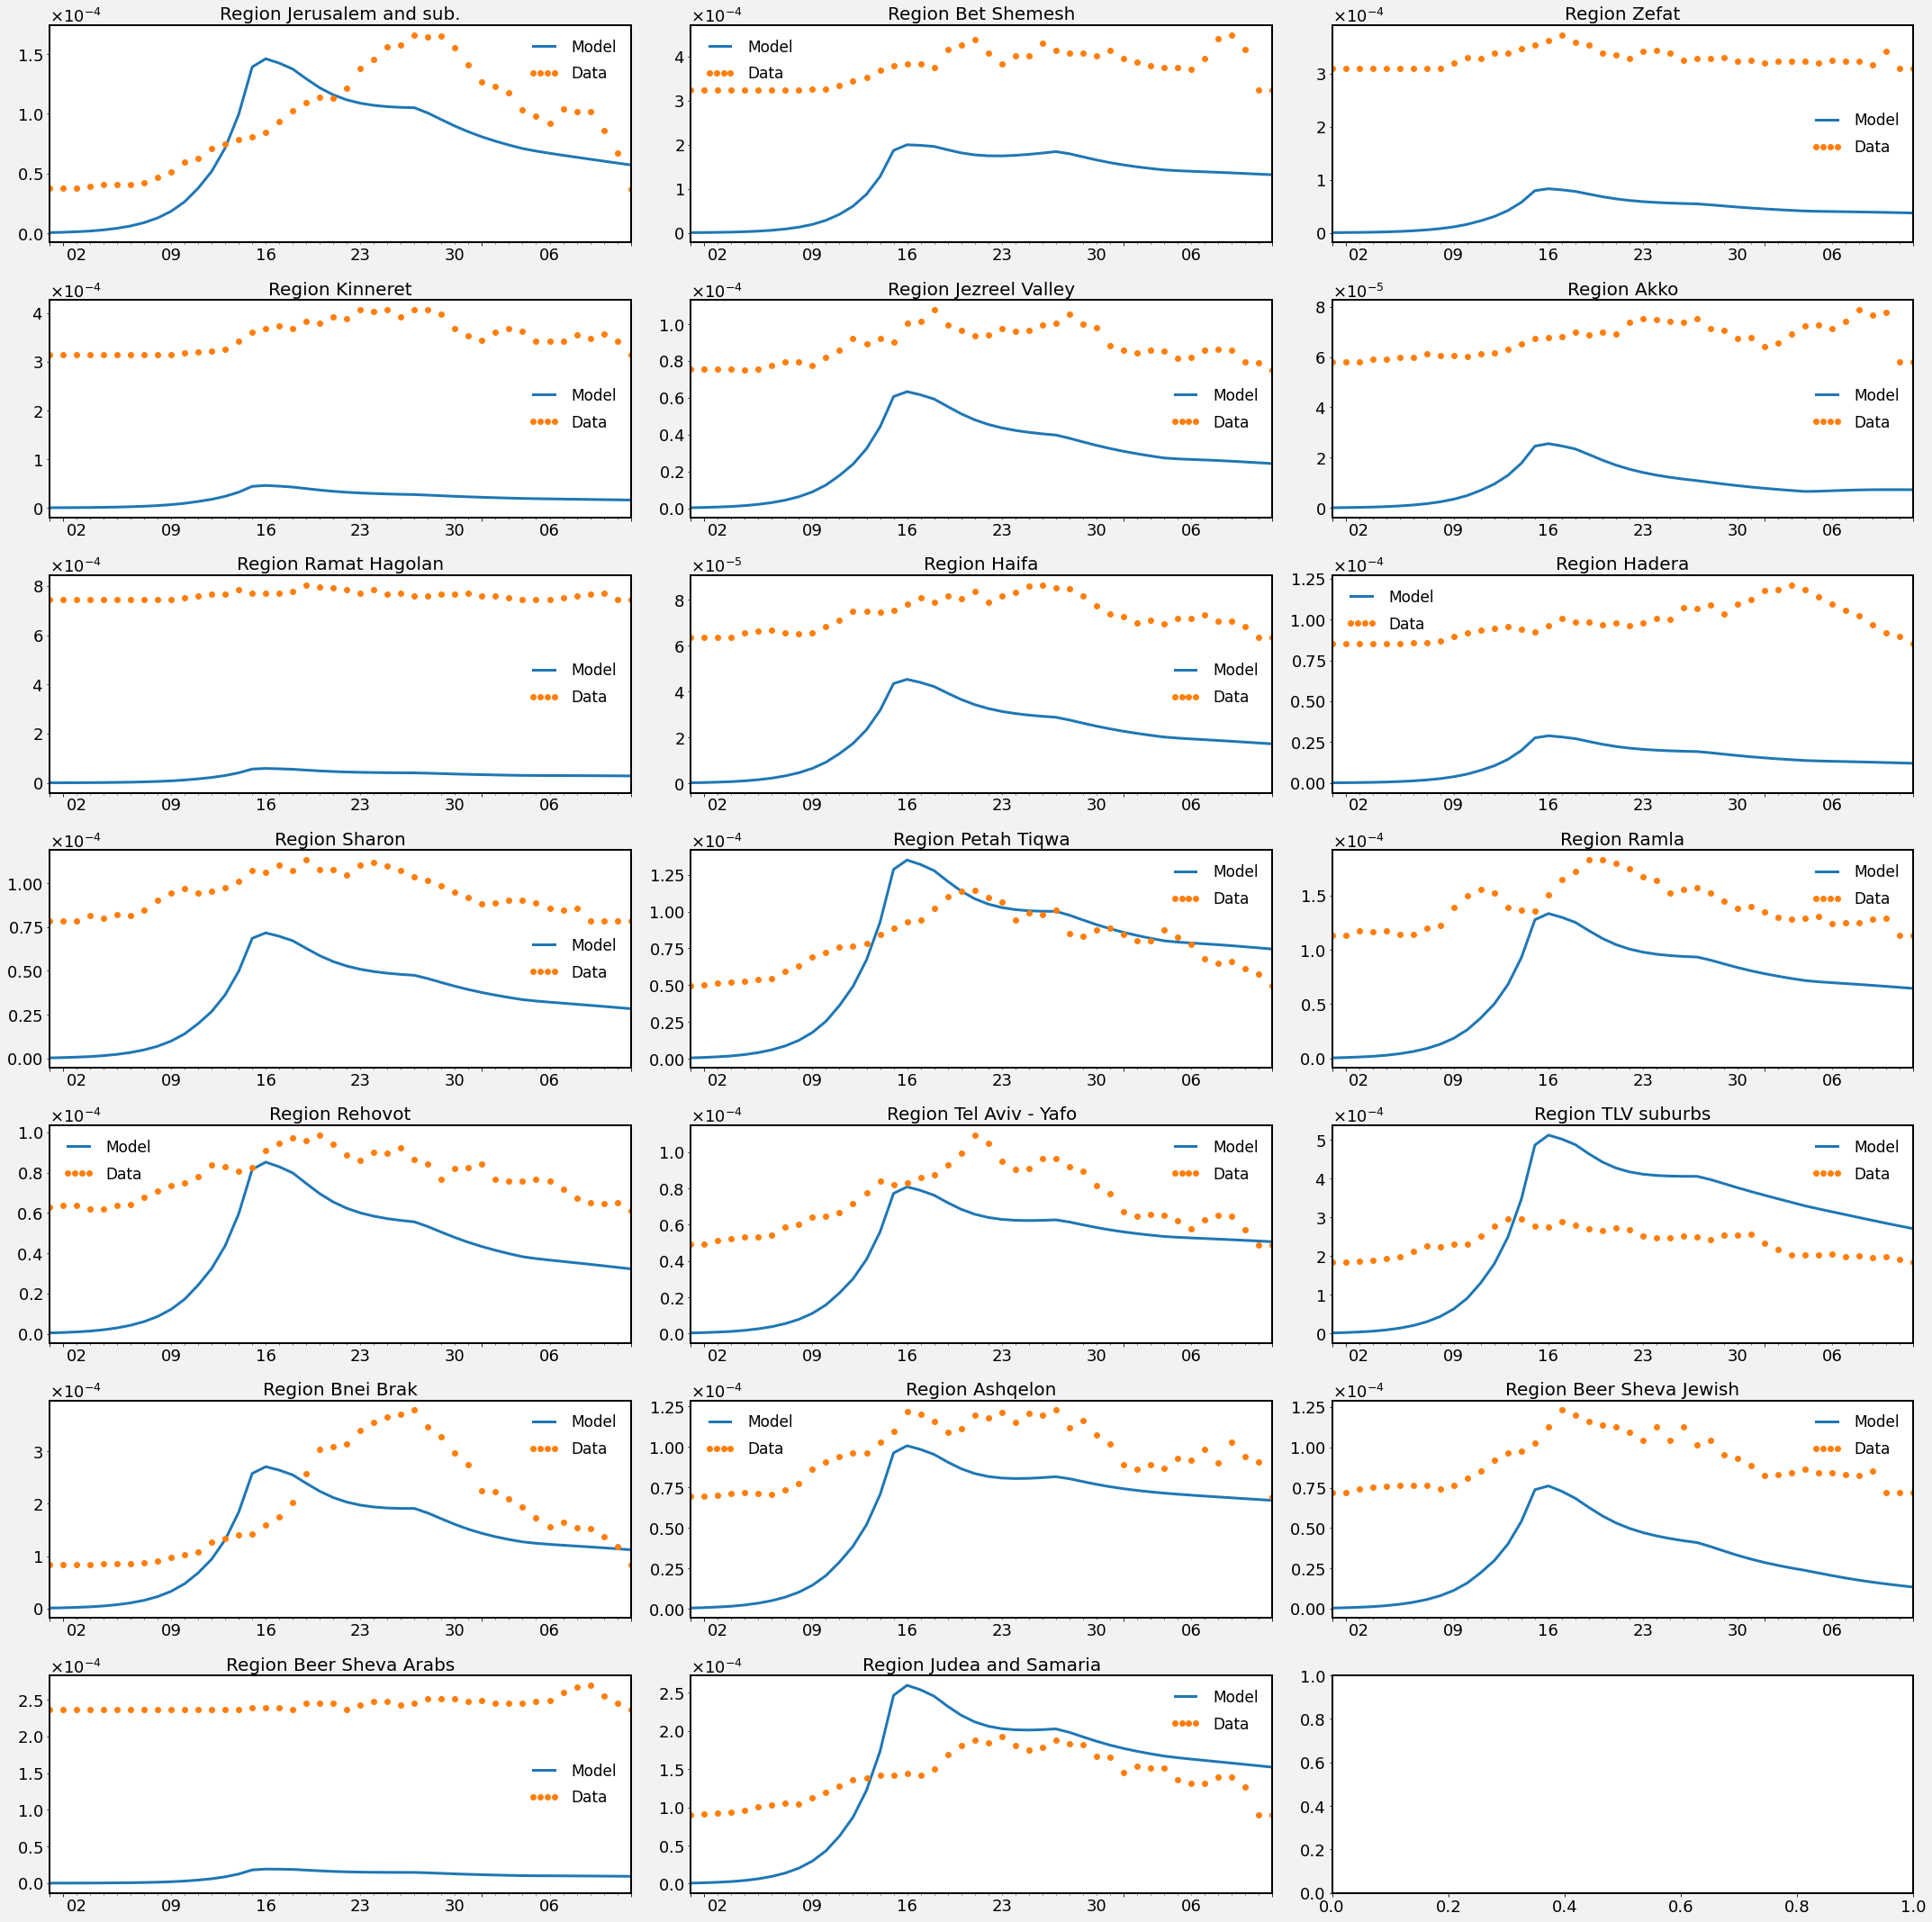

In [59]:
# plotting the data and model
fig,ax = mdl.plot_calibrated_model_region(data=data_ub, 
                                          mdl_data = res_mdl_ub['new_Is'],
                                          date_list = date_lst,
                                          start='2020-02-29',
                                          end='2020-04-12',
                                          region_name = mdl.cell,
                                          loss_func = 'MSE')
fig.set_size_inches((30,30))
plt.tight_layout()
plt.show()

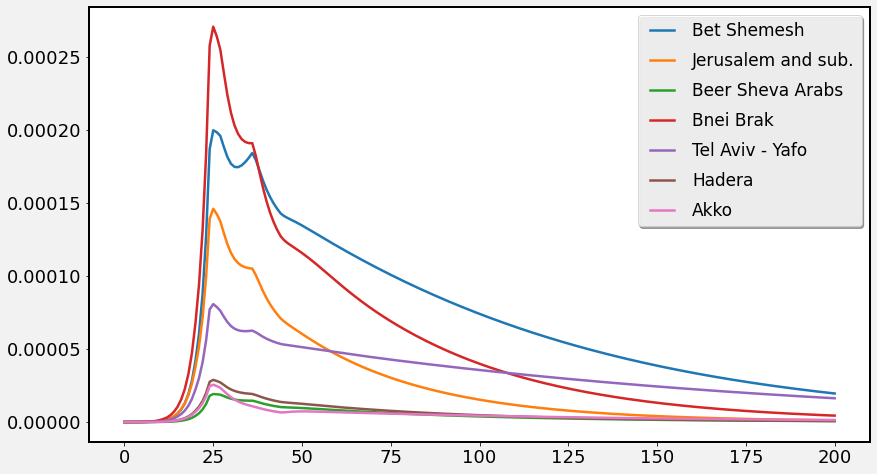

In [60]:
# Creating table 1, by region:
tabel_1_dict = {}
for region in ['11_betshemesh','11','62_arab','51_bb','51','32','24']:
    tabel_1_dict[mdl.cell[region]] = (res_mdl_ub['new_Is'][:, mdl.region_dict[region]].sum(axis=1))/mdl.population_size[mdl.region_dict[region]].sum()
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

tabel1_df.iloc[:].plot()

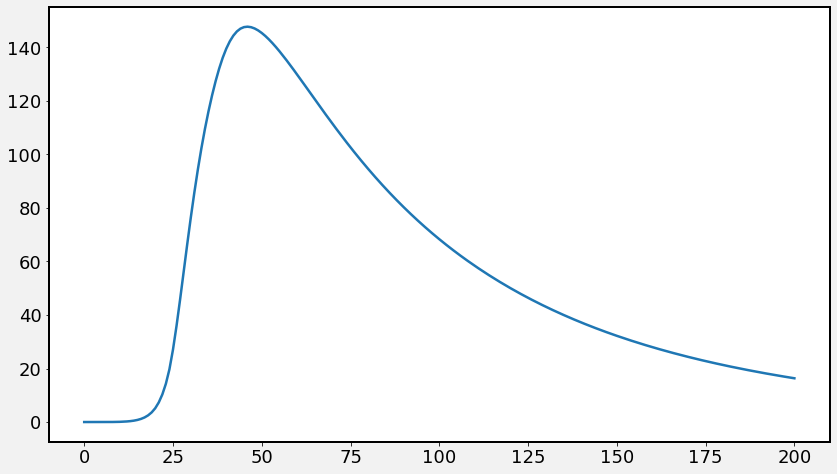

In [61]:
plt.plot(res_mdl_ub['H'].sum(axis=1)*9136000)

In [62]:
res_mdl_ub['new_Is'].sum()

0.005584832177592786

In [63]:
res_mdl['new_Is'][:55].sum(axis=1).sum()*9136000

11422.462861304366

(<Figure size 1008x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28ee28b47c8>)

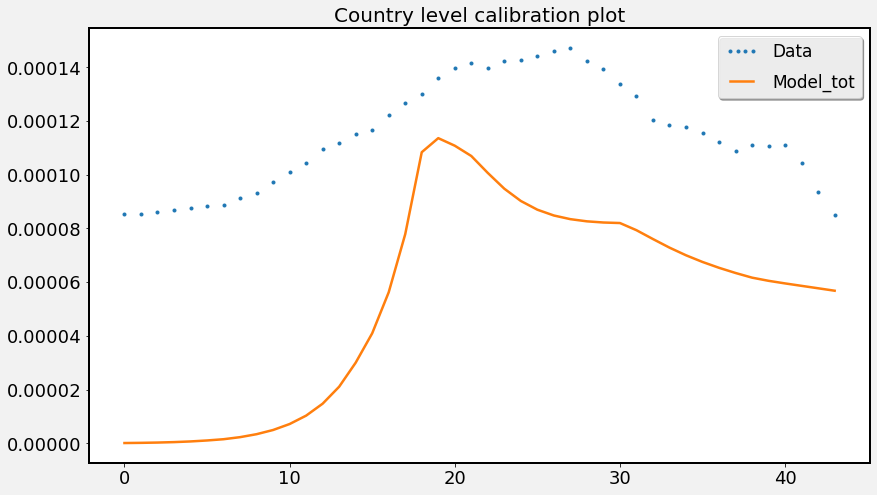

In [69]:
mdl.plot_calibrated_total_model(pd.DataFrame(data_ub[1])/9136000,res_mdl_ub,date_lst,start='2020-02-26',end='2020-04-09')

## Fit LB

In [67]:
# LB data:
data_lb = data.copy()
data_lb[1] = ((data[1]/9136000)*(1/3.))*isr_pop # beacuse the data_ub is 3 times bigger than data (on average)

In [71]:
model_lb = mdl.Model_behave(
    beta_j=np.array([0.02927922 ,0.02927922 ,0.02927922 ,0.04655266,0.04655266,0.05775265,0.05775265,0.18444245,0.18444245]),
    theta=2.826729434860104,
    beta_behave=0.5552998605894367,
    eps=mdl.eps_sector['Scenario2'],
    f=mdl.f0_full['Scenario2'],
    sigma=1/4.4,
    nu = 0.1
)

In [72]:
# Model Fitting
days_in_season=70
p0=(0.0981001,0.05305112,0.05157651,0.3,2.103427546494595, 0.23785134529029744) # initial guess
bnds = ((0,0.15),(0,0.15),(0,0.15),(0,0.54),(1.5,3),(0,0.7))# boundries for variables

In [73]:
res_fit_lb = model_lb.fit(
        p0=p0,
        bnds=bnds,
        data=data_lb,
        date_lst = date_lst,
        days_in_season=days_in_season,
        start='2020-02-26',
        end='2020-04-09',
        loss_func='MSE',
        maxiter=300,
        factor=1,
    )

iter:  50  loss:  -27.181030403365632
iter:  100  loss:  -27.324005094863548
iter:  150  loss:  -27.417889748892193
iter:  200  loss:  -27.452283765212307
iter:  250  loss:  -27.49589854121468
iter:  300  loss:  -27.03173309774277
iter:  350  loss:  -27.50822747279203
iter:  400  loss:  -27.5082782293353
iter:  450  loss:  -27.508957219664442
iter:  500  loss:  -27.509046834169368
iter:  550  loss:  -27.509182819102385
iter:  600  loss:  -27.509185786333546
iter:  650  loss:  -27.50918760527744
iter:  700  loss:  -27.509188734289065
iter:  750  loss:  -27.509189261310294
iter:  800  loss:  -27.509189977173456
iter:  850  loss:  -27.509155259072585
iter:  900  loss:  -27.50919363380787
iter:  950  loss:  -27.50917881555753
iter:  1000  loss:  -27.509196094579124
iter:  1050  loss:  -27.509192847682876
iter:  1100  loss:  -27.509196678626083
iter:  1150  loss:  -27.484799518613286
iter:  1200  loss:  -27.509669911238706
iter:  1250  loss:  -27.51009349570677
iter:  1300  loss:  -27.51010

In [74]:
mdl.print_stat_fit_behave(res_fit_lb)

minimized value: -27.53311302804272
Fitted parameters:
 Beta=[0.04909444 0.02292042 0.01912638 0.1331989 ]
 Theta=2.839846134144761,
 Beta_behave=0.4244872199315455
num of sampling the target function: 300


In [78]:
model_lb.reset()
res_mdl_lb = model_lb.predict(
    C=mdl.C_calibration,
    days_in_season=200,
    stay_home_idx=mdl.stay_home_idx,
    not_routine=mdl.not_routine,
)

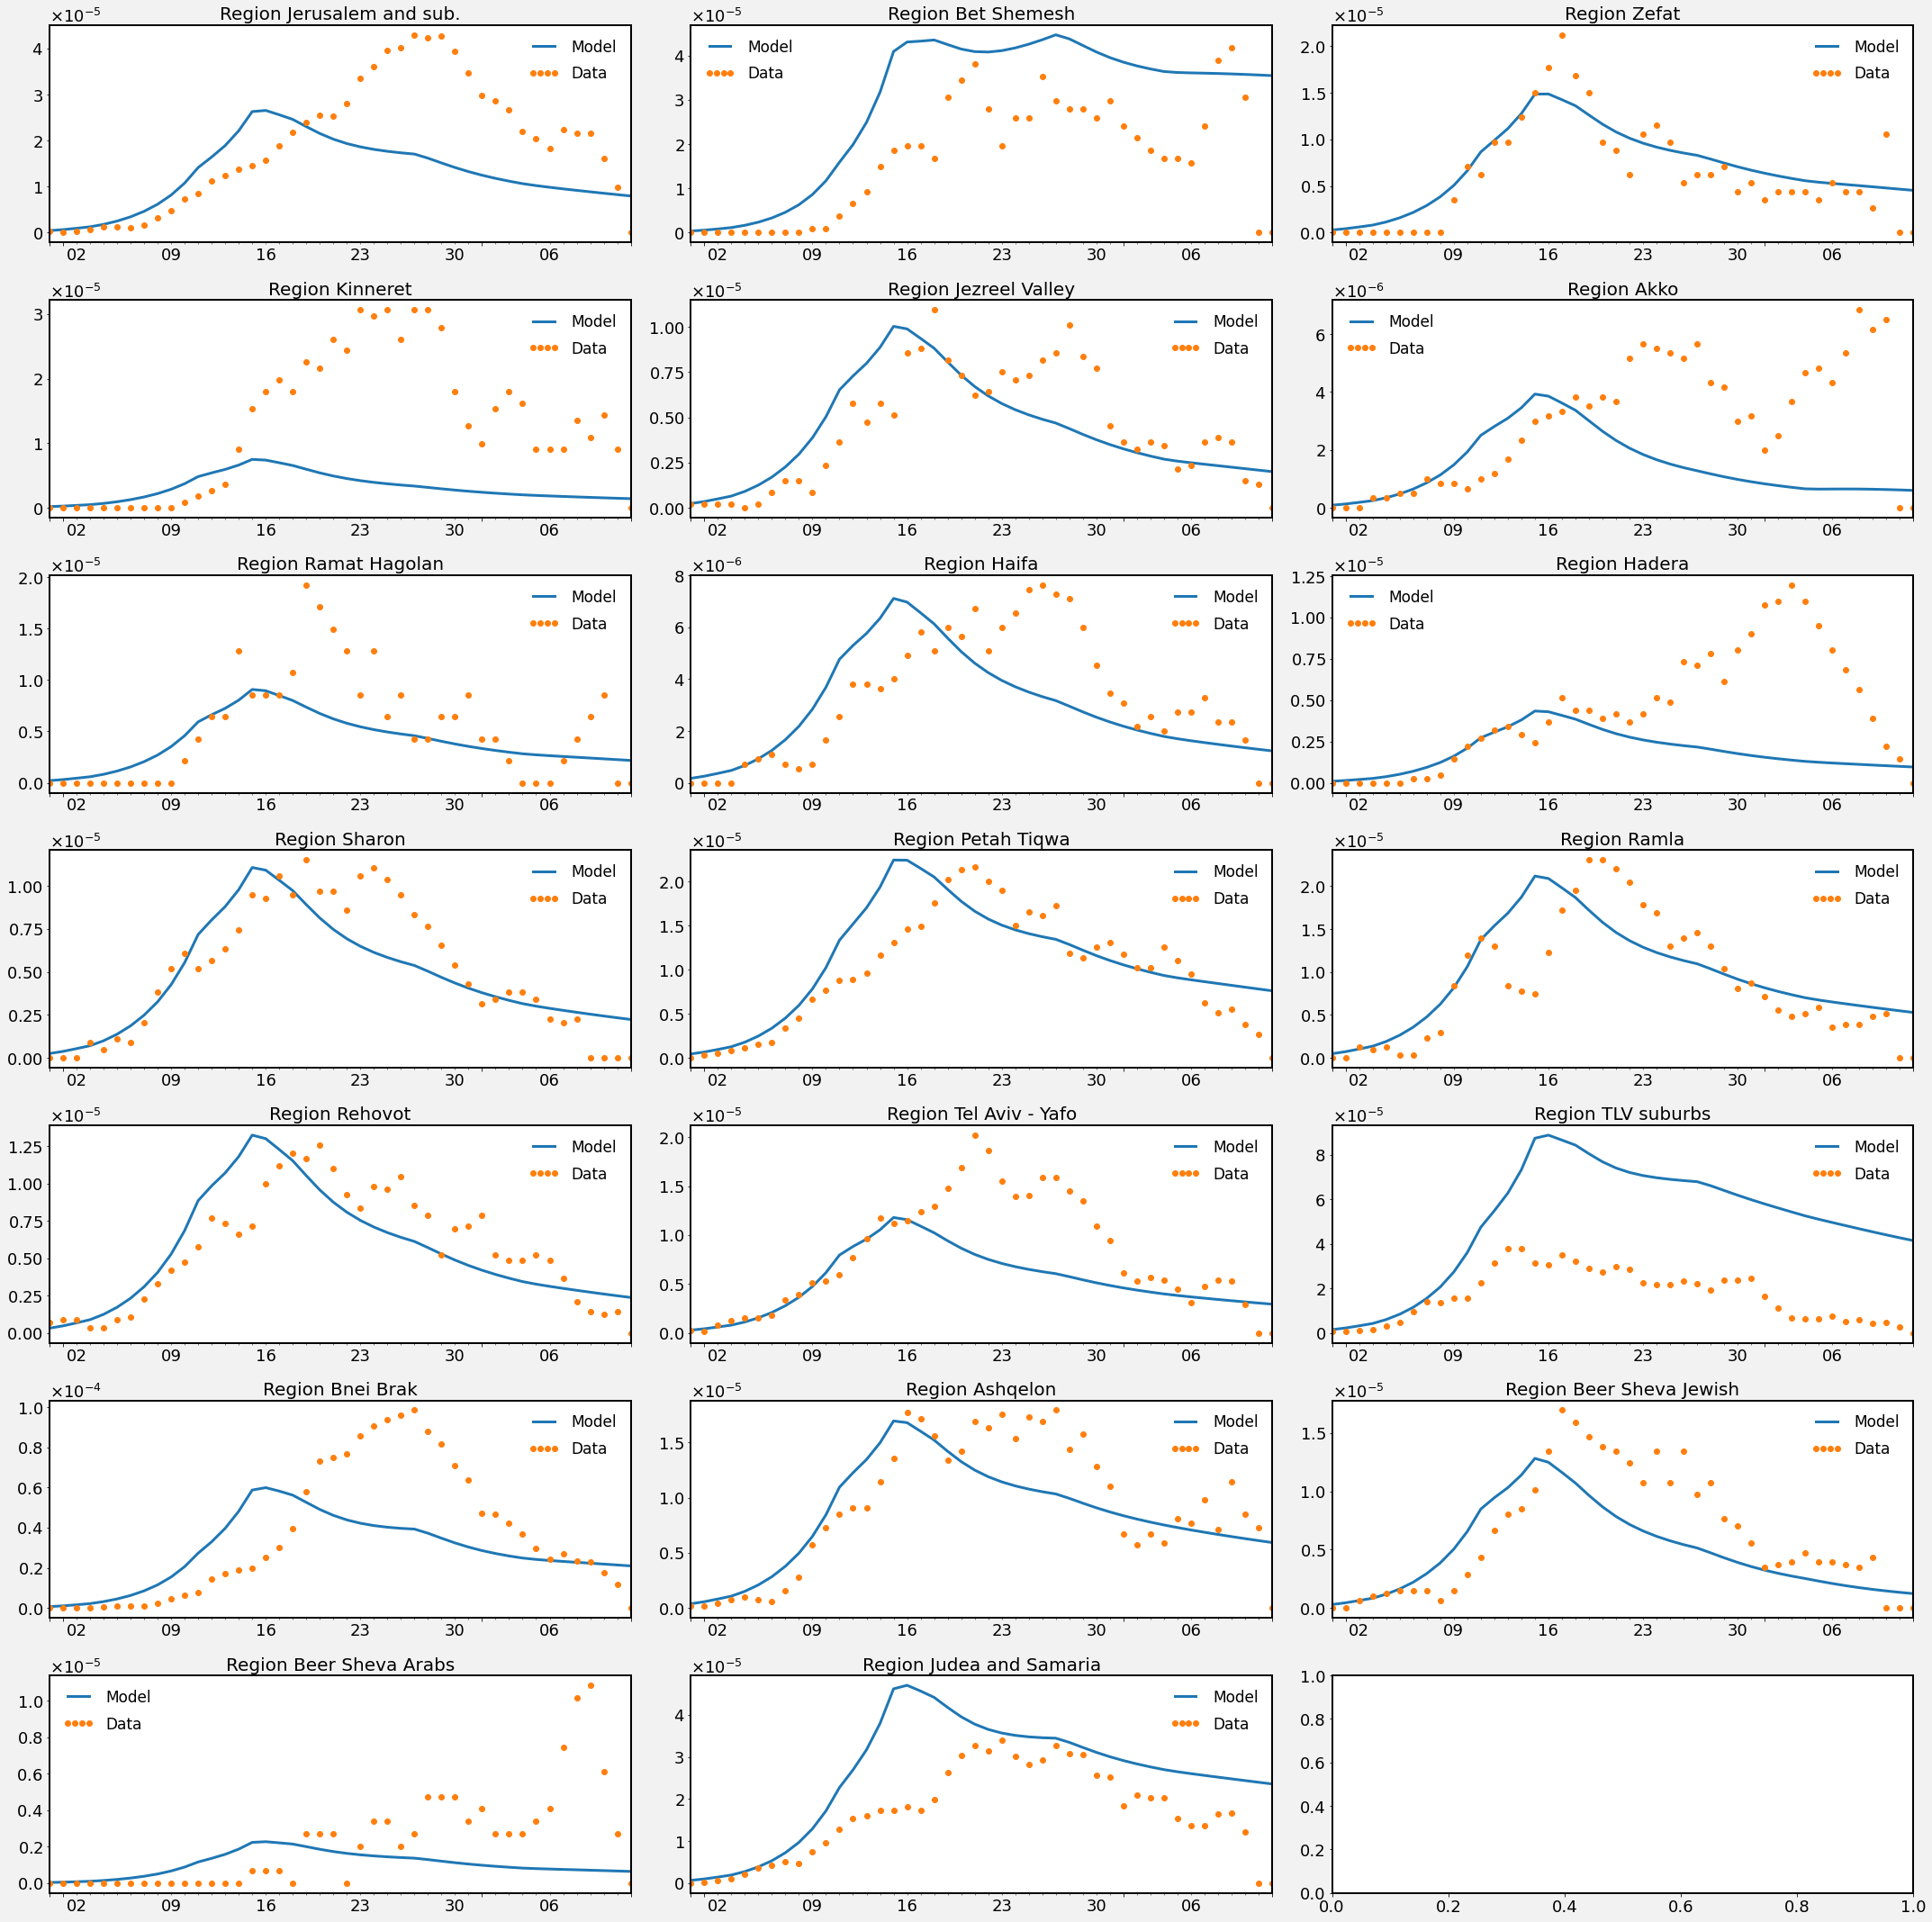

In [76]:
# plotting the data and model
fig,ax = mdl.plot_calibrated_model_region(data=data_lb, 
                                          mdl_data = res_mdl_ub_lb['new_Is'],
                                          date_list = date_lst,
                                          start='2020-02-29',
                                          end='2020-04-12',
                                          region_name = mdl.cell,
                                          loss_func = 'MSE')
fig.set_size_inches((30,30))
plt.tight_layout()
plt.show()

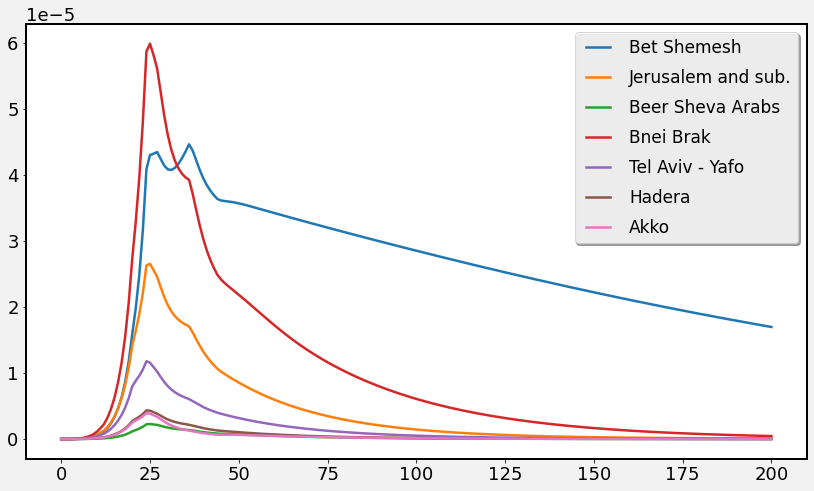

In [79]:
# Creating table 1, by region:
tabel_1_dict = {}
for region in ['11_betshemesh','11','62_arab','51_bb','51','32','24']:
    tabel_1_dict[mdl.cell[region]] = (res_mdl_lb['new_Is'][:, mdl.region_dict[region]].sum(axis=1))/mdl.population_size[mdl.region_dict[region]].sum()
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

tabel1_df.iloc[:].plot()

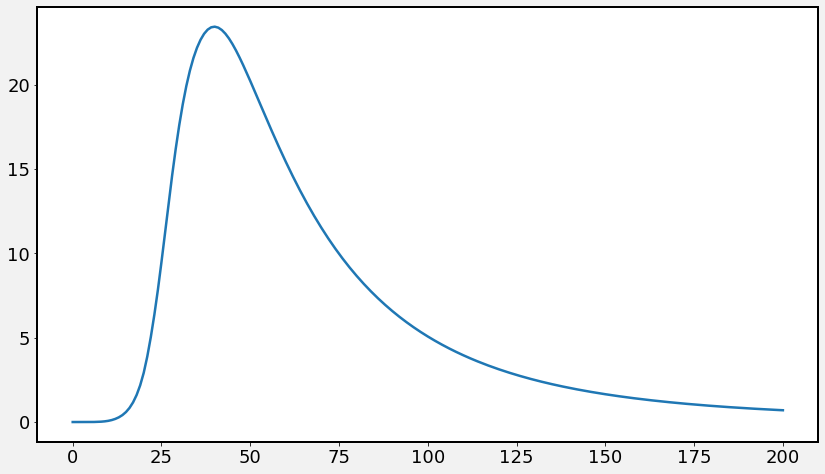

In [80]:
plt.plot(res_mdl_lb['H'].sum(axis=1)*9136000)

In [81]:
res_mdl_lb['new_Is'][:55].sum(axis=1).sum()

0.00044320859930587045

(<Figure size 1008x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28ee24a5a08>)

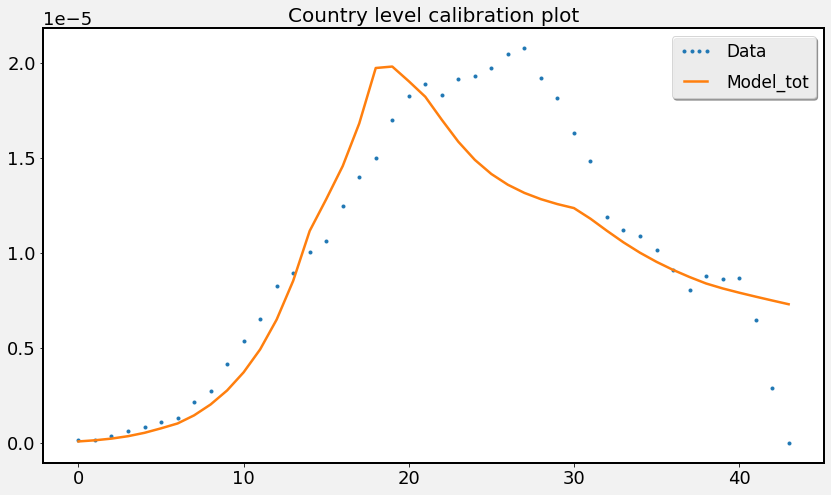

In [82]:
mdl.plot_calibrated_total_model(pd.DataFrame(data_lb[1])/9136000,res_mdl_lb,date_lst,start='2020-02-26',end='2020-04-09')

# Amit's fit

## Data old

In [24]:
# data = pd.read_csv('../Data/sick/old_data2003_1304.csv', index_col=0)
# data.head()

## Scenario 2

In [25]:
# fit params
days_in_season=70
date_lst = pd.date_range('2020-02-20',last)
len(date_lst)

54

In [96]:
# Model Fitting
p0=(0.03574392,0.0680812,0.07149694,0.24919698,1.8512674898217287, 0.40194272460656777) # initial guess
bnds = ((0,0.1),(0,0.15),(0,0.15),(0,0.3),(1.5,3),(0,0.6))# boundries for variables
res_fit = []
fitted_params = []
fitted_beta = []
theta = []
######## Doind Exp:
######## checking shift, different losses, and factors:
for i, (factor, shift, loss) in enumerate(itertools.product(
    [1 ,10 ,100, 500, 1000],
    np.arange(-7, 7, 1),
    ['MSE', 'BIN', 'POIS', 'POIS_NAIV'],
)):
    print('Checking combination: ', (factor, shift, loss))
    #defining shift
    pos_shift = pos.copy()
    tot_shift = tot.copy()
    pos_shift.index = pd.DatetimeIndex(pos.index + pd.DateOffset(shift))
    tot_shift.index = pd.DatetimeIndex(tot.index + pd.DateOffset(shift))
    pos_shift.index = pd.to_datetime(pos_shift.index)
    tot_shift.index = pd.to_datetime(tot_shift.index)
    min_d = max([pos_shift.index.values.min(), first])
    max_d = min([pos_shift.index.values.max(), last])
    pos_shift = pos_shift.loc[pd.date_range(min_d,max_d)]
    tot_shift = tot_shift.loc[pd.date_range(min_d,max_d)]
    
    data = np.ndarray((2,len(pos_shift), len(mdl.GA.values())))
    data[0] = tot_shift
    data[1] = pos_shift
    
    res_fit.append(model.fit(
        p0=p0,
        bnds=bnds,
        data=data,
        date_lst = date_lst,
        days_in_season=days_in_season,
        start=min_d,
        end=max_d,
        loss_func=loss,
        maxiter=300,
        factor=factor,
    ))
    # errorfunc(tpl,data,f,season_length, eps, alpha)


    fitted_params.append(res_fit.x)

    # run the fitted model:
    fitted_beta.append(np.array([fitted_params[0], fitted_params[0], fitted_params[0], fitted_params[1], fitted_params[1],\
                            fitted_params[2], fitted_params[2], fitted_params[3], fitted_params[3]]))
    theta.append(fitted_params[4])
    beta_behave.append(fitted_params[5])
                        
# print data stat
mdl.print_stat_fit_behave(res_fit)


Checking combination:  (1, -7, 'MSE')
iter:  50  loss:  -24.417526001936896
iter:  100  loss:  -24.78465318081429
iter:  150  loss:  -24.7954446019401
iter:  200  loss:  -24.801256059212246
iter:  250  loss:  -24.81054238018346
iter:  300  loss:  -24.813893869109652
iter:  350  loss:  -24.81374899234063
iter:  400  loss:  -24.80498127858645


KeyboardInterrupt: 

In [13]:
# # last
# fitted_beta = [0.08401885, 0.0498636, 0.04742293, 0.29044575]
# fitted_beta = np.array([fitted_beta[0], fitted_beta[0], fitted_beta[0], 
#                    fitted_beta[1], fitted_beta[1], 
#                    fitted_beta[2], fitted_beta[2], 
#                    fitted_beta[3], fitted_beta[3]])
# theta = 1.7884756534064268
# beta_behave = 0.3114150965784499

In [14]:
# model.update({
#     'beta_j': fitted_beta,
#     'theta': theta,
#     'beta_behave': beta_behave,
# })

In [15]:
model.reset()
res_mdl = model.predict(
    C=mdl.C_calibration,
    days_in_season=200,
    stay_home_idx=mdl.stay_home_idx,
    not_routine=mdl.not_routine,
)

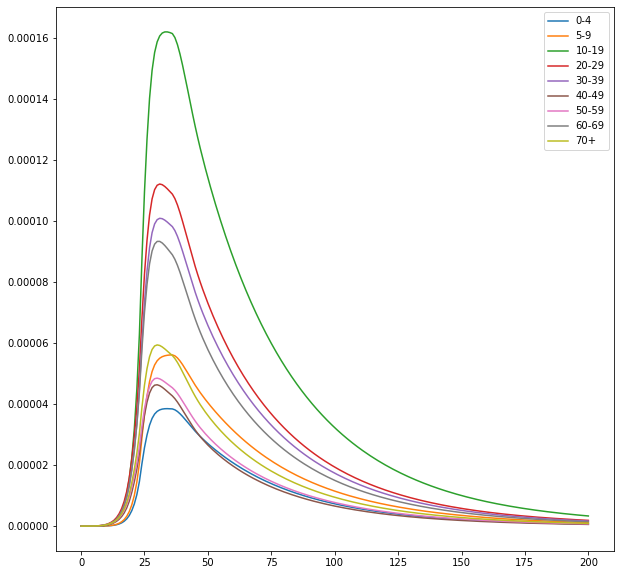

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x9b476a0>)

In [16]:
mdl.plot_I_by_age(res_mdl)

In [17]:
res_mdl['new_Is'].sum()

0.002522545709324517

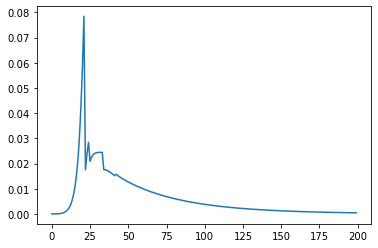

In [18]:
plt.plot((res_mdl['L'].sum(axis=1)))

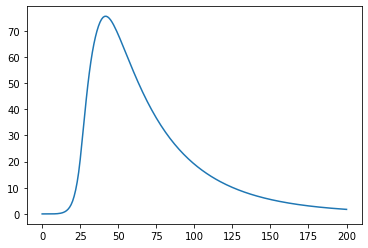

In [19]:
plt.plot((res_mdl['H'].sum(axis=1))*9136000)

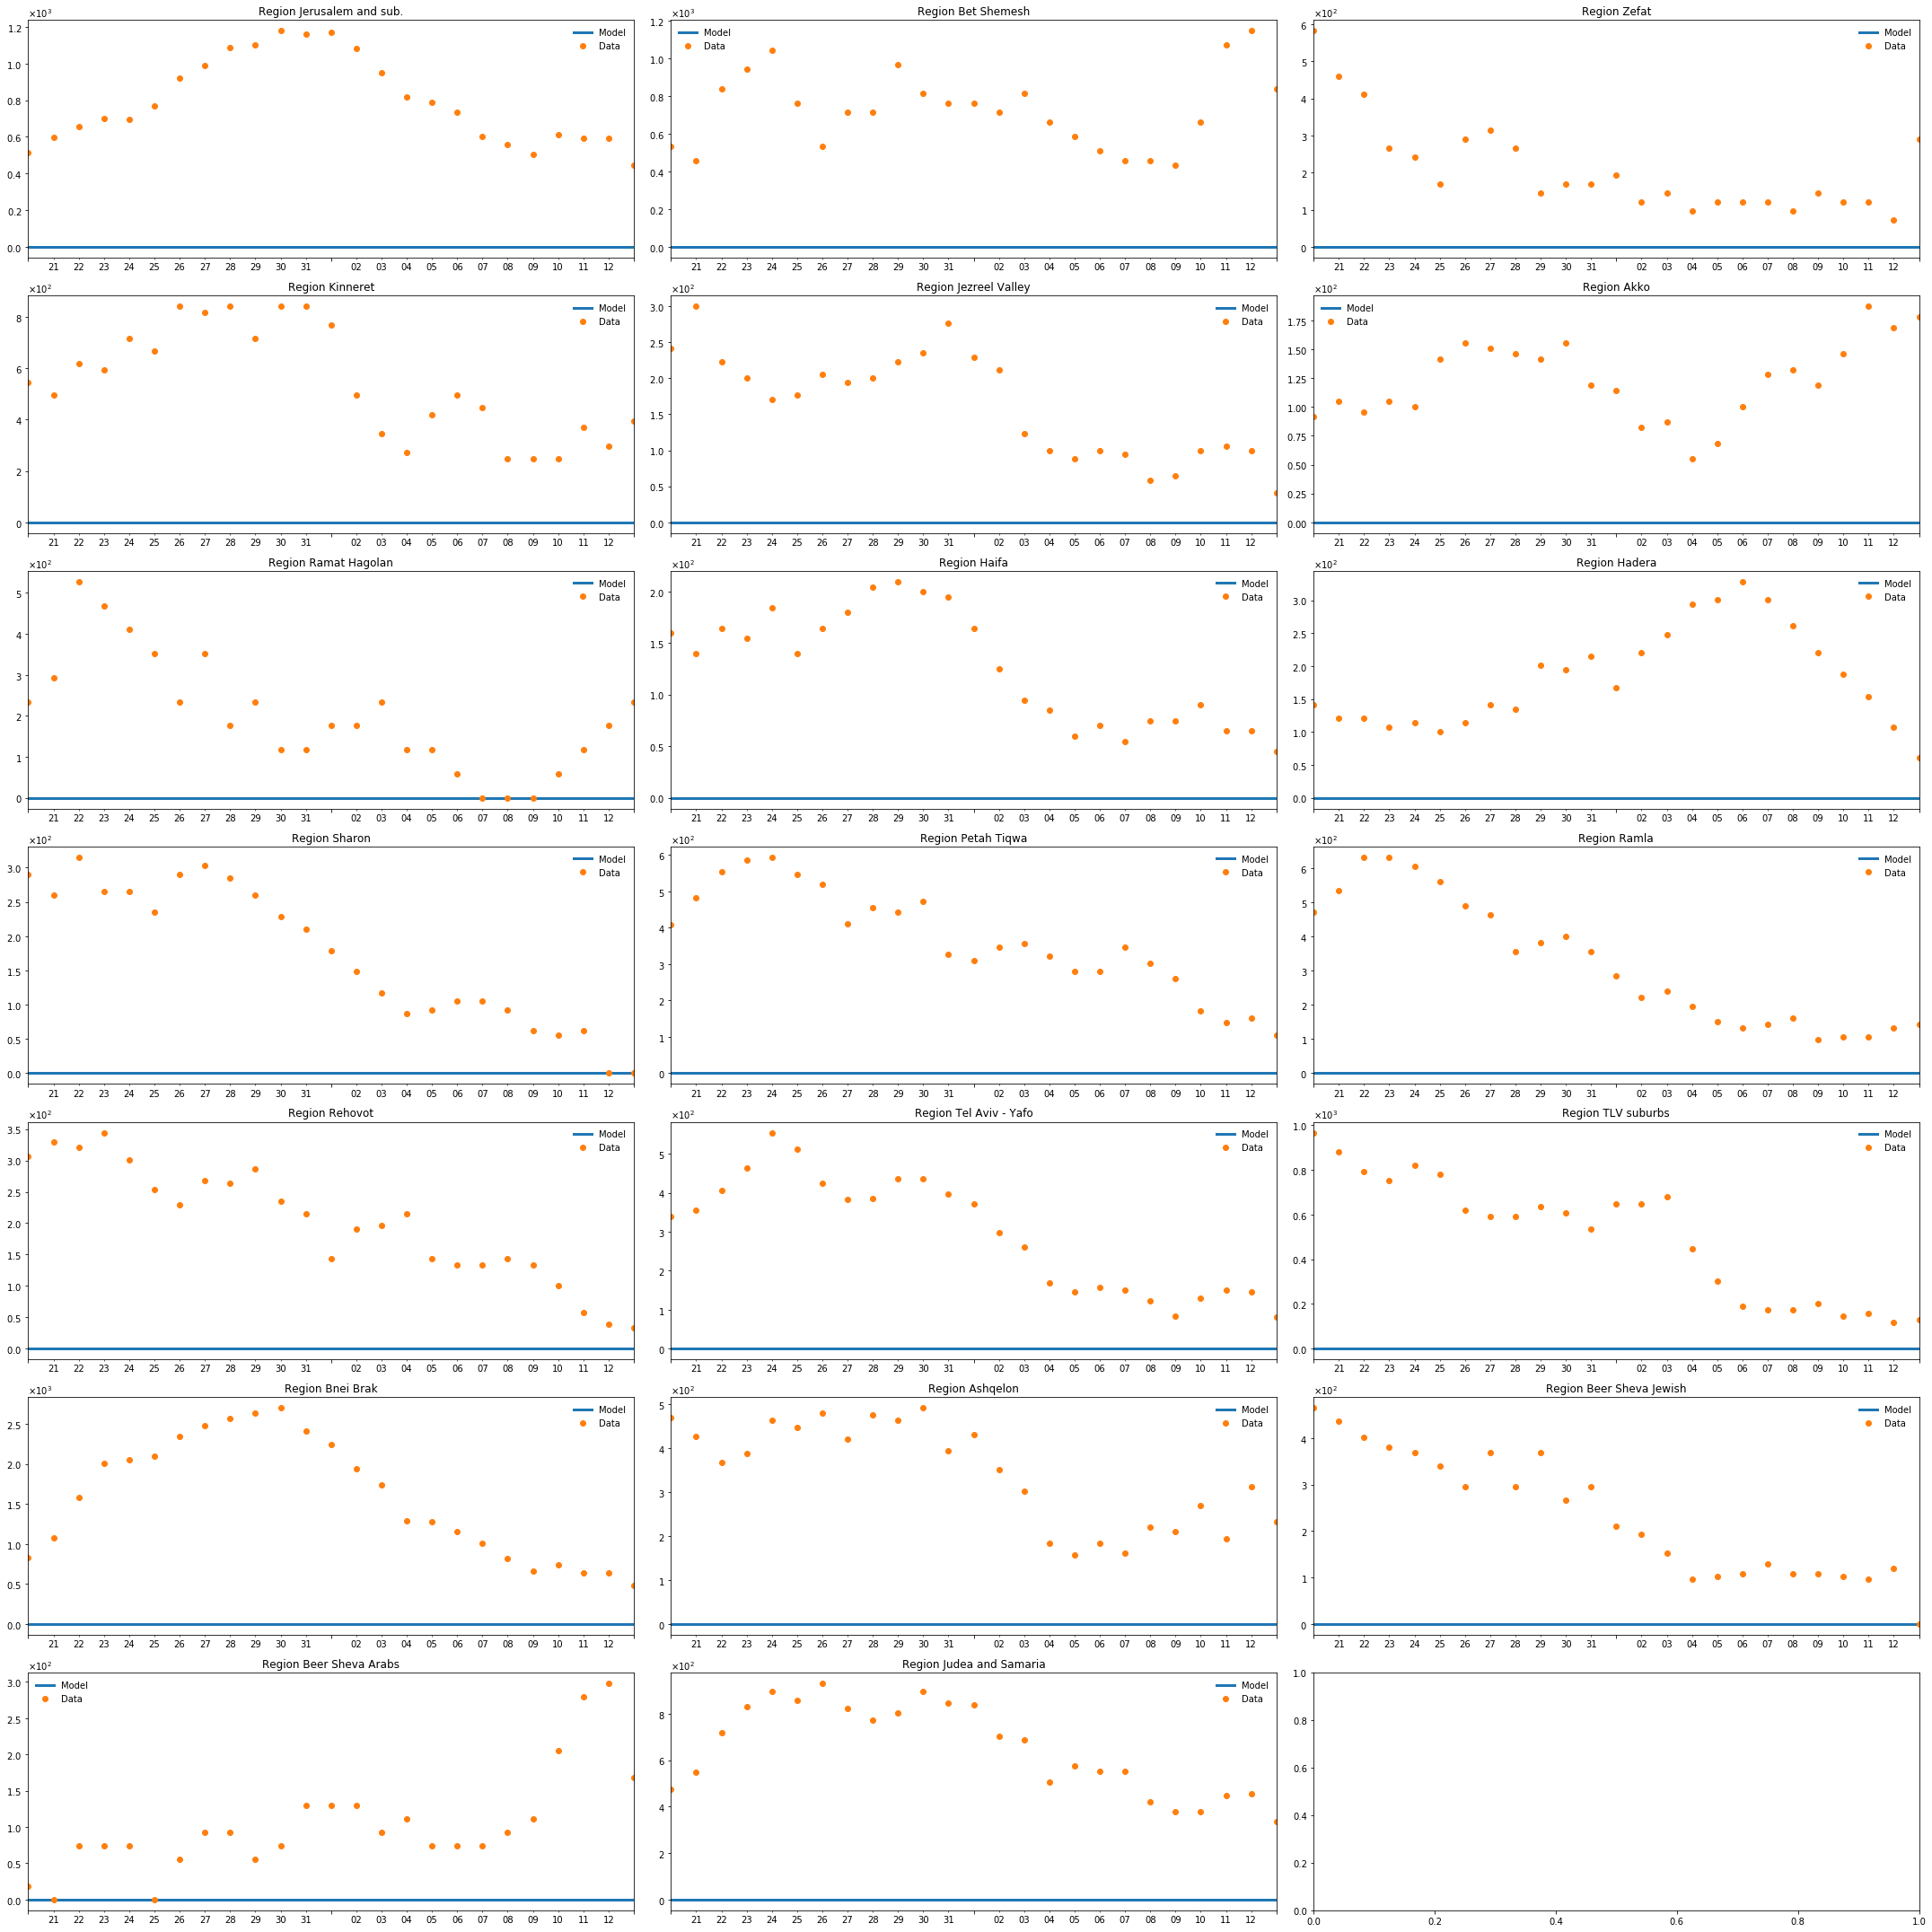

In [21]:
# plotting the data and model
fig,ax = mdl.plot_calibrated_model_region(data=data, 
                                          mdl_data = res_mdl['new_Is'],
                                          date_list = date_lst,
                                          start=first,
                                          end=last,
                                          region_name = mdl.cell,
                                          loss_func = 'Pois_Naiv')
fig.set_size_inches((30,30))
plt.tight_layout()
plt.show()

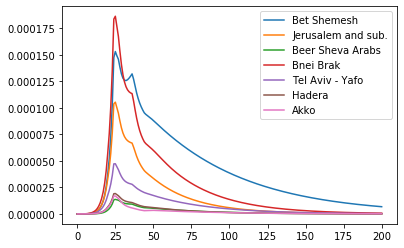

In [22]:
# Creating table 1, by region:
tabel_1_dict = {}
for region in ['11_betshemesh','11','62_arab','51_bb','51','32','24']:
    tabel_1_dict[mdl.cell[region]] = (res_mdl['new_Is'][:, mdl.region_dict[region]].sum(axis=1))/mdl.population_size[mdl.region_dict[region]].sum()
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

tabel1_df.iloc[:].plot()

## old fit results

In [16]:
# best old fit results:
# alpha=1
# beta_j=np.array([0.02927922 ,0.02927922 ,0.02927922 ,0.04655266,0.04655266,0.05775265,0.05775265,0.18444245,0.18444245])
# theta=2.826729434860104
# beta_behave=0.5552998605894367
fitted_beta = [0.08401885, 0.0498636, 0.04742293, 0.29044575]
fitted_beta = np.array([beta_j[0], beta_j[0], beta_j[0], 
                   beta_j[1], beta_j[1], 
                   beta_j[2], beta_j[2], 
                   beta_j[3], beta_j[3]])
theta = 1.7884756534064268
beta_behave = 0.3114150965784499

In [3]:
res_mdl = mdl.run_sector_model_behave(beta_home=0.38/9., theta=theta, beta_j=beta_j, beta_behave=beta_behave,
                                        eps=mdl.eps_sector['Scenario2'], f=mdl.f0_full['Scenario2'], alpha=alpha, 
                                        days_in_season=175, nu=1/10.)

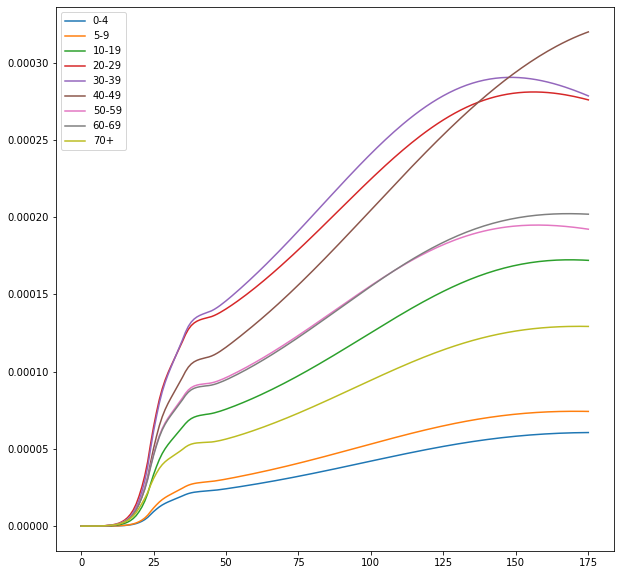

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x4cc2c50>)

In [4]:
mdl.plot_I_by_age(res_mdl)

In [5]:
res_mdl['new_Is'].sum()

0.014201607353994087

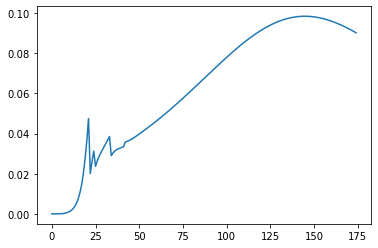

In [6]:
plt.plot((res_mdl['L'].sum(axis=1)))

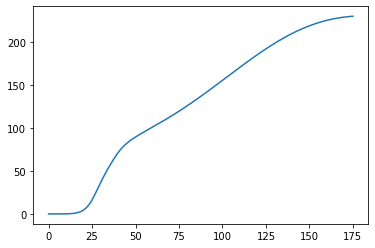

In [7]:
plt.plot((res_mdl['H'].sum(axis=1))*9136000)

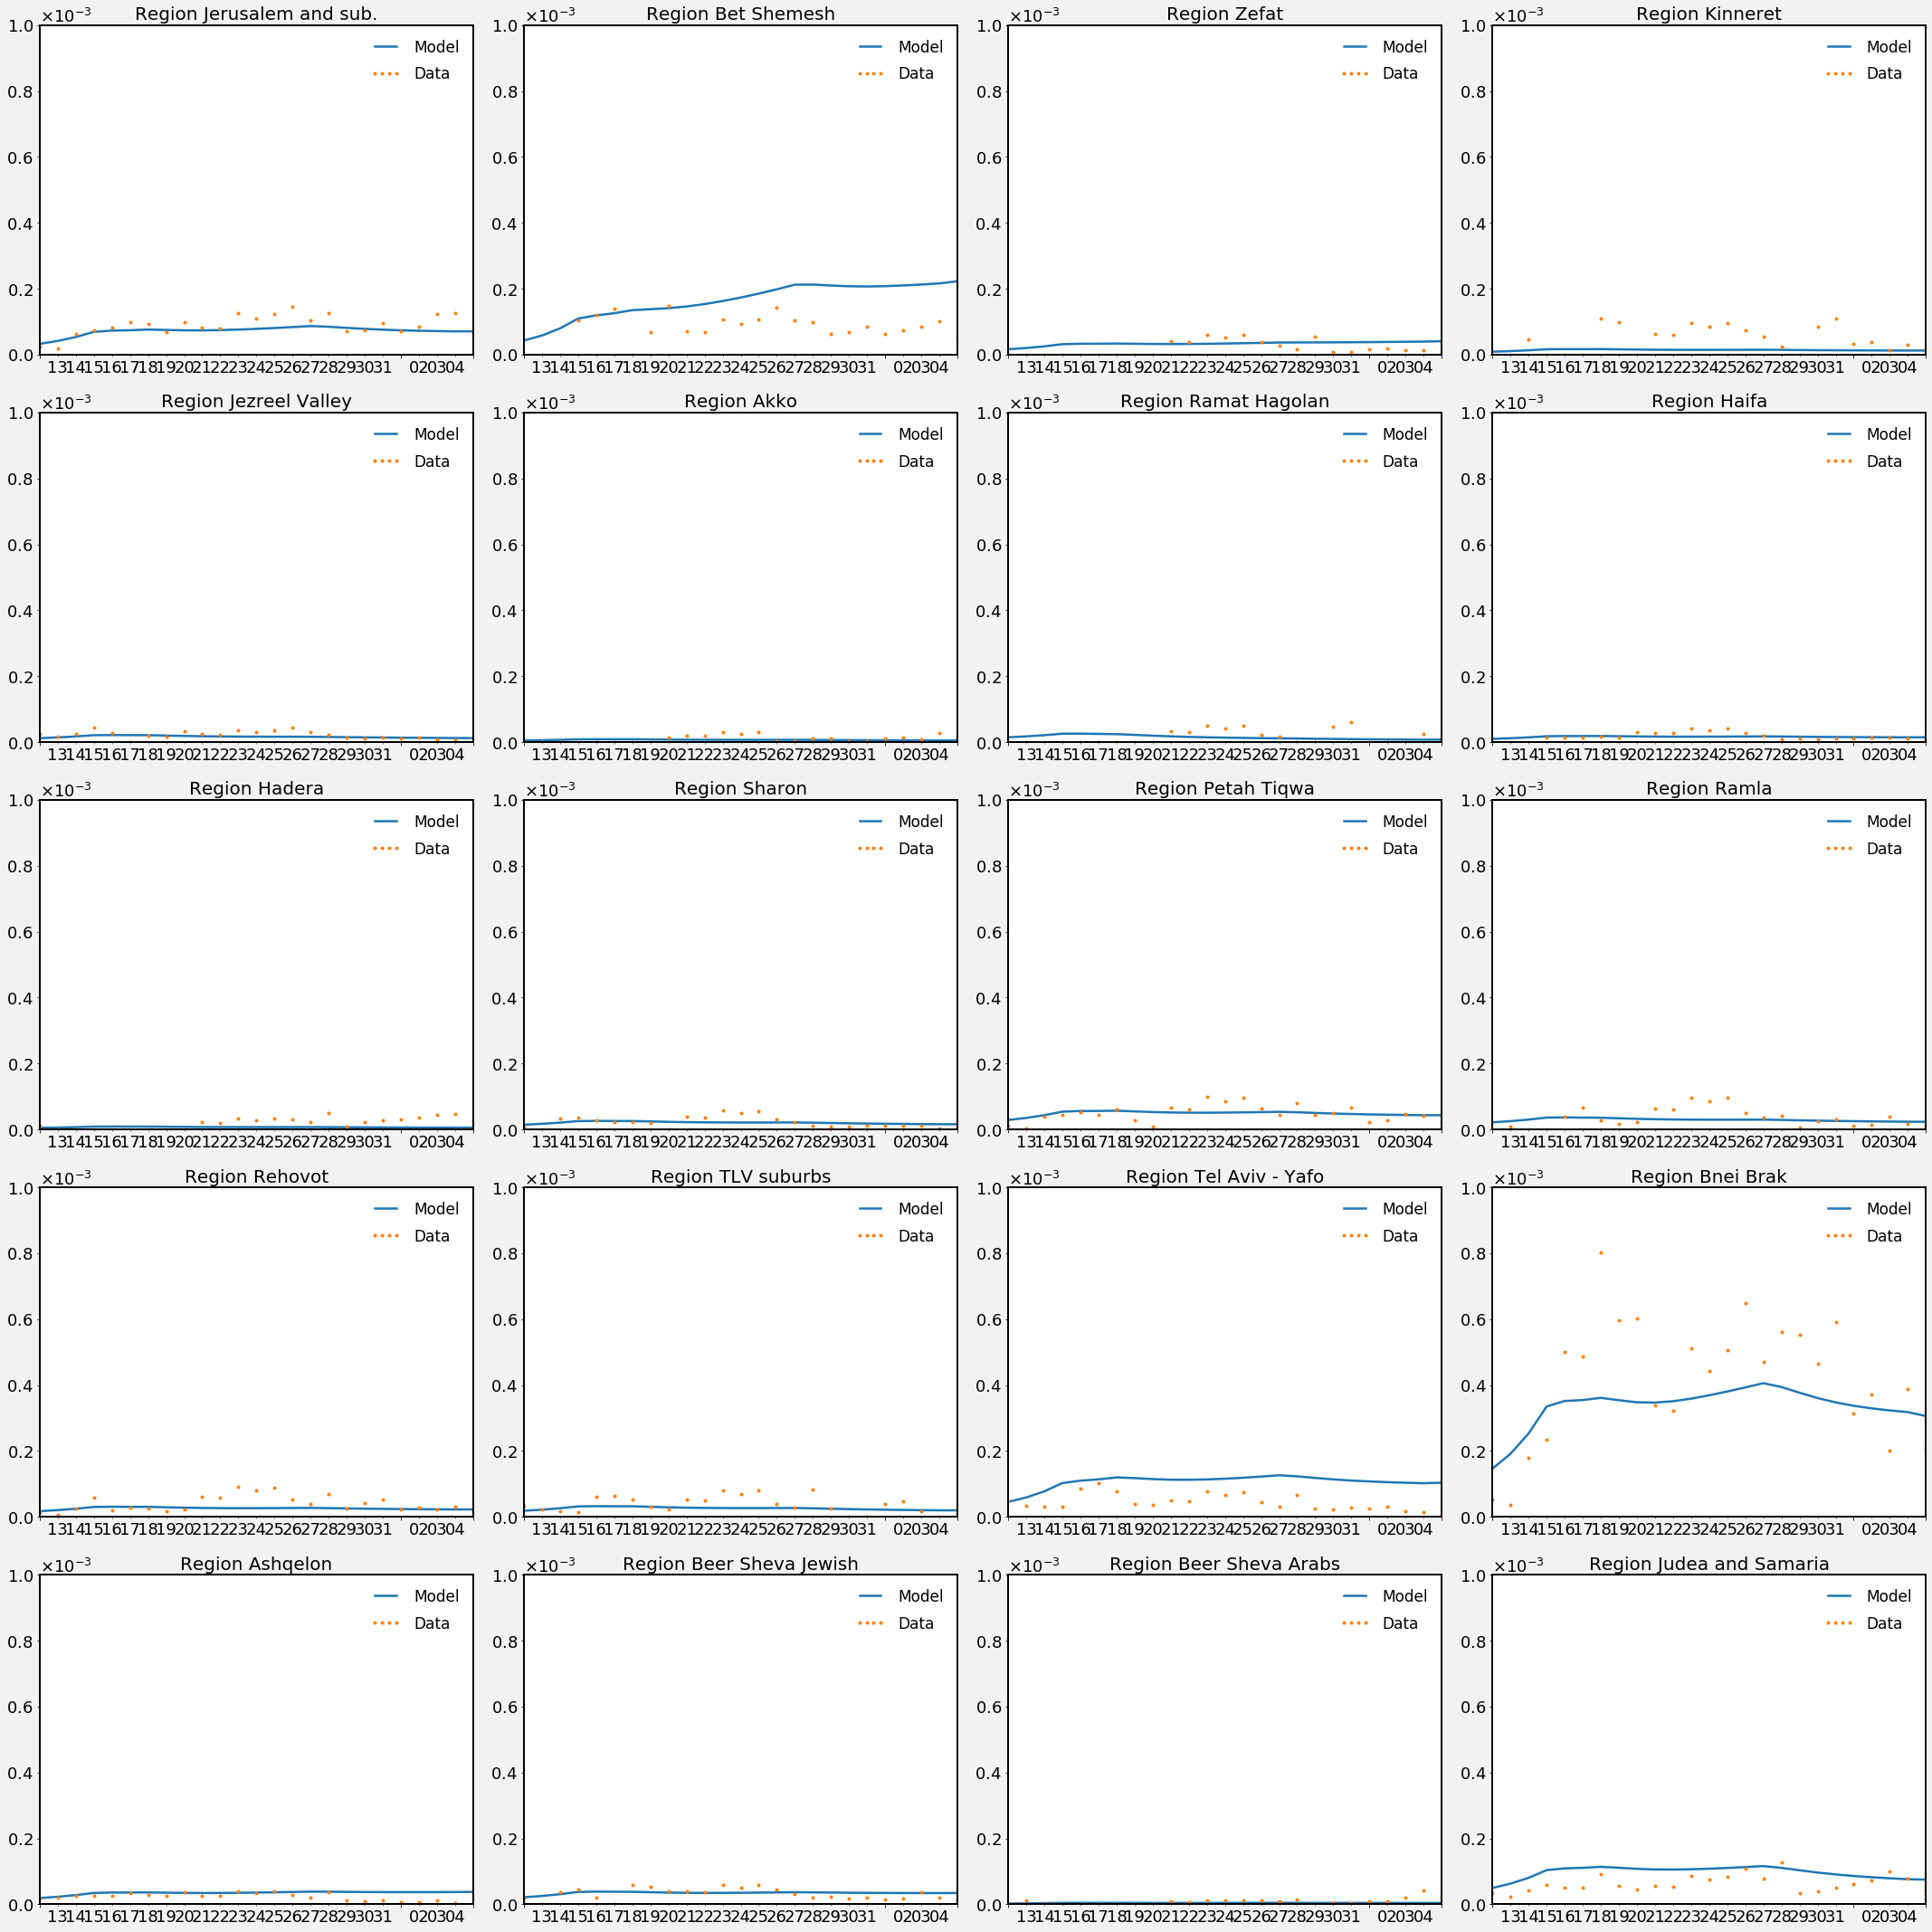

In [9]:
# plotting the data and model
fig,ax = mdl.plot_calibrated_model_region(data=data.values, mdl_data = res_mdl['new_Is'],date_list = date_lst,
                                         start='2020-03-12',end='2020-04-05')
fig.set_size_inches((30,30))
plt.tight_layout()
plt.show()

(<Figure size 1008x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1434480fa20>)

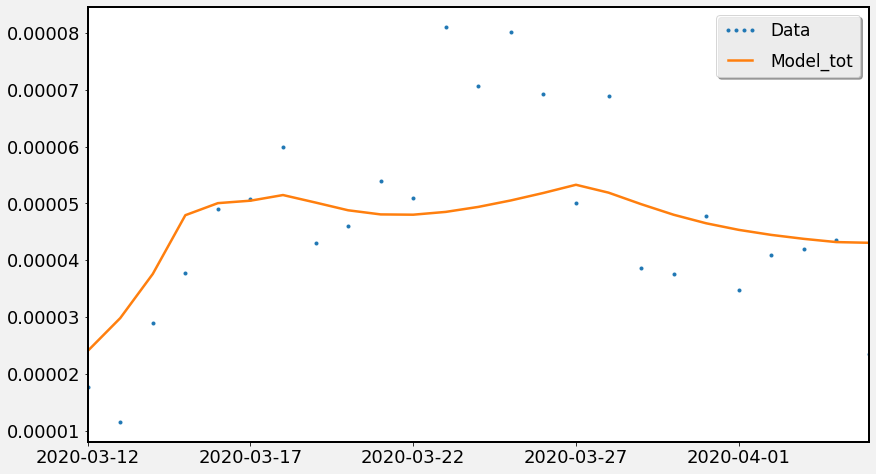

In [10]:
mdl.plot_calibrated_total_model(data=data, mdl_data=res_mdl, date_list=date_lst, 
                            start='2020-03-12', end='2020-04-05')

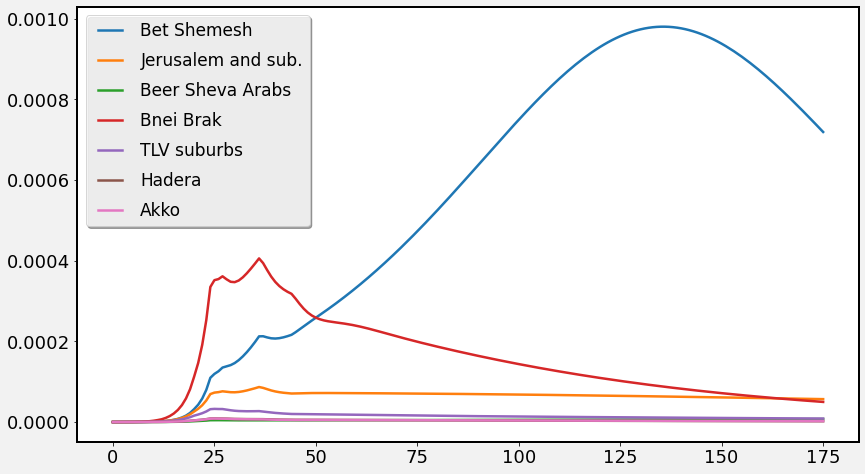

In [19]:
# Creating table 1, by region:
tabel_1_dict = {}
for region in ['11_betshemesh','11','62_arab','51_bb','51','32','24']:
    tabel_1_dict[mdl.region_name[region]] = (res_mdl['new_Is'][:, mdl.region_dict[region]].sum(axis=1))/mdl.population_size[mdl.region_dict[region]].sum()
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

tabel1_df.iloc[:].plot()

In [15]:
res_mdl['new_Is'].sum()

0.015901764064386696

In [ ]:
ven_proba = pd.read_csv('Data/vent_proba.csv')
# Creating table 1, by region:
tabel_1_dict = {}
for region in ['11_betshemesh','11','62_arab','51_bb','51','32','24']:
    tabel_1_dict[mdl.region_name[region]] = (res_mdl['new_Is'][:, mdl.region_dict[region]].sum(axis=1))/mdl.population_size[mdl.region_dict[region]].sum()
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

tabel1_df.iloc[:].plot()

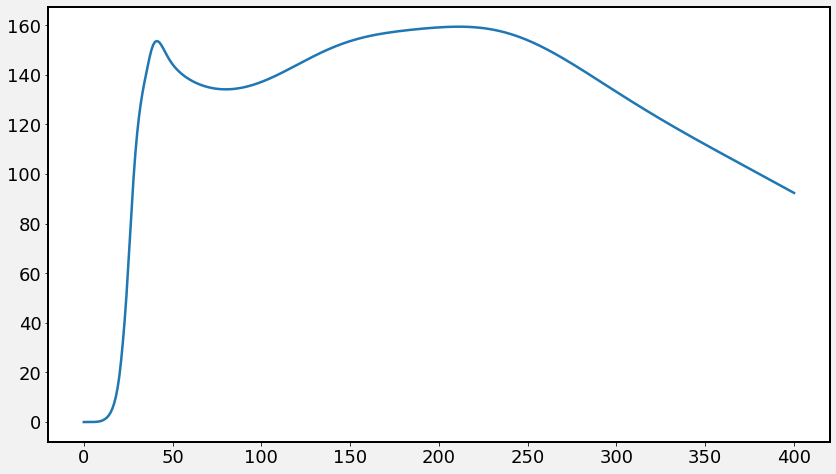

In [14]:
plt.plot((res_mdl['H'].sum(axis=1))*9136000)

In [16]:
(res_mdl['H'].sum(axis=1))[56]*9136000

139.85616268520099

In [17]:
((res_mdl['Is'][:, mdl.age_dict['70+']].sum(axis=1))[56]+(res_mdl['Is'][:, mdl.age_dict['60-69']].sum(axis=1))[56])/(res_mdl['Is'][:].sum(axis=1))[56]

0.19352028004453542

In [18]:
(res_mdl['R'].sum(axis=1))[56]*9136000*0.3

8920.626073952297

### Data with variance

In [19]:
start_idx = int(np.where(date_lst == '2020-03-12')[0])
end_idx = int(np.where(date_lst == '2020-04-05')[0])

In [26]:
model_by_age_region = {}
for i, key in enumerate(mdl.region_age_dict.keys()):
    model_by_age_region[key[0] + '_' + key[1] + '_mdl'] = res_mdl['new_Is'][start_idx:end_idx+1, mdl.region_age_dict[key]].sum(axis=1)
model_by_age_region = pd.DataFrame.from_dict(model_by_age_region)

In [27]:
# Calculating model variance:
std = np.sqrt((np.power(data.values - model_by_age_region.values,2).sum())/(data.values.size - 1))

In [28]:
std

2.542541093307999e-07

### Upper bound calibration

In [ ]:
# minimized value: -25.112767900678186
# Fitted parameters:
#  Beta=[0.03030602 0.05262323 0.06149524 0.2050433 ]
#  Theta=2.328913039368483,
#  Beta_behave=0.5297713948054046
# num of sampling the target function: 173

In [29]:
# Calculating data with adding std
ub_data = data + 2*std

In [3]:
# fit params
days_in_season_ub=70
alpha_ub=1
date_lst = pd.date_range('2020-02-20','2020-04-13')

In [31]:
# Model Fitting
p0=(0.06862921,0.07089788,0.08567678,0.3,1.5103006972556037, 0.4293725726208387) # initial guess
bnds = ((0,0.1),(0,0.15),(0,0.15),(0,0.6),(1,3),(0,1))# boundries for variables
# errorfunc(tpl,data,f,season_length, eps, alpha)
res_fit_ub= optimize.minimize(mdl.errorfunc_by_sector_behavior,p0,bounds=bnds,method='TNC',args=(ub_data.values,mdl.f0_full['Scenario2'],
                                                                           days_in_season_ub,mdl.eps_sector['Scenario2'],alpha_ub,date_lst,
                                                                                    '2020-03-12-','2020-04-05')
                           ,options={'maxiter':1000})

fitted_params_ub = res_fit_ub.x

# run the fitted model:
fitted_beta_ub = np.array([fitted_params_ub[0], fitted_params_ub[0], fitted_params_ub[0], fitted_params_ub[1], fitted_params_ub[1],\
                        fitted_params_ub[2], fitted_params_ub[2], fitted_params_ub[3], fitted_params_ub[3]])
theta_ub = fitted_params_ub[4]
beta_behave_ub = fitted_params_ub[5]
                        
# print data stat
mdl.print_stat_fit_behave(res_fit_ub)

minimized value: -24.050377053060725
Fitted parameters:
 Beta=[0.06872524 0.07058089 0.0849962  0.35823708]
 Theta=1.5147969877267358,
 Beta_behave=0.4195811609779443
num of sampling the target function: 156


In [4]:
# best fit results:
beta_j_ub=np.array([0.06872524,0.06872524,0.06872524,0.07058089,0.07058089,0.0849962,0.0849962,0.35823708,0.35823708])
theta_ub=1.5147969877267358
beta_behave_ub=0.4195811609779443

In [5]:
res_mdl_ub = mdl.run_sector_model_behavior(beta_home=0.38/9., theta=theta_ub, beta_j=beta_j_ub, beta_behave=beta_behave_ub,
                                        eps=mdl.eps_sector['Scenario2'], f=mdl.f0_full['Scenario2'], alpha=alpha_ub, 
                                        days_in_season=175,new=1./10.)

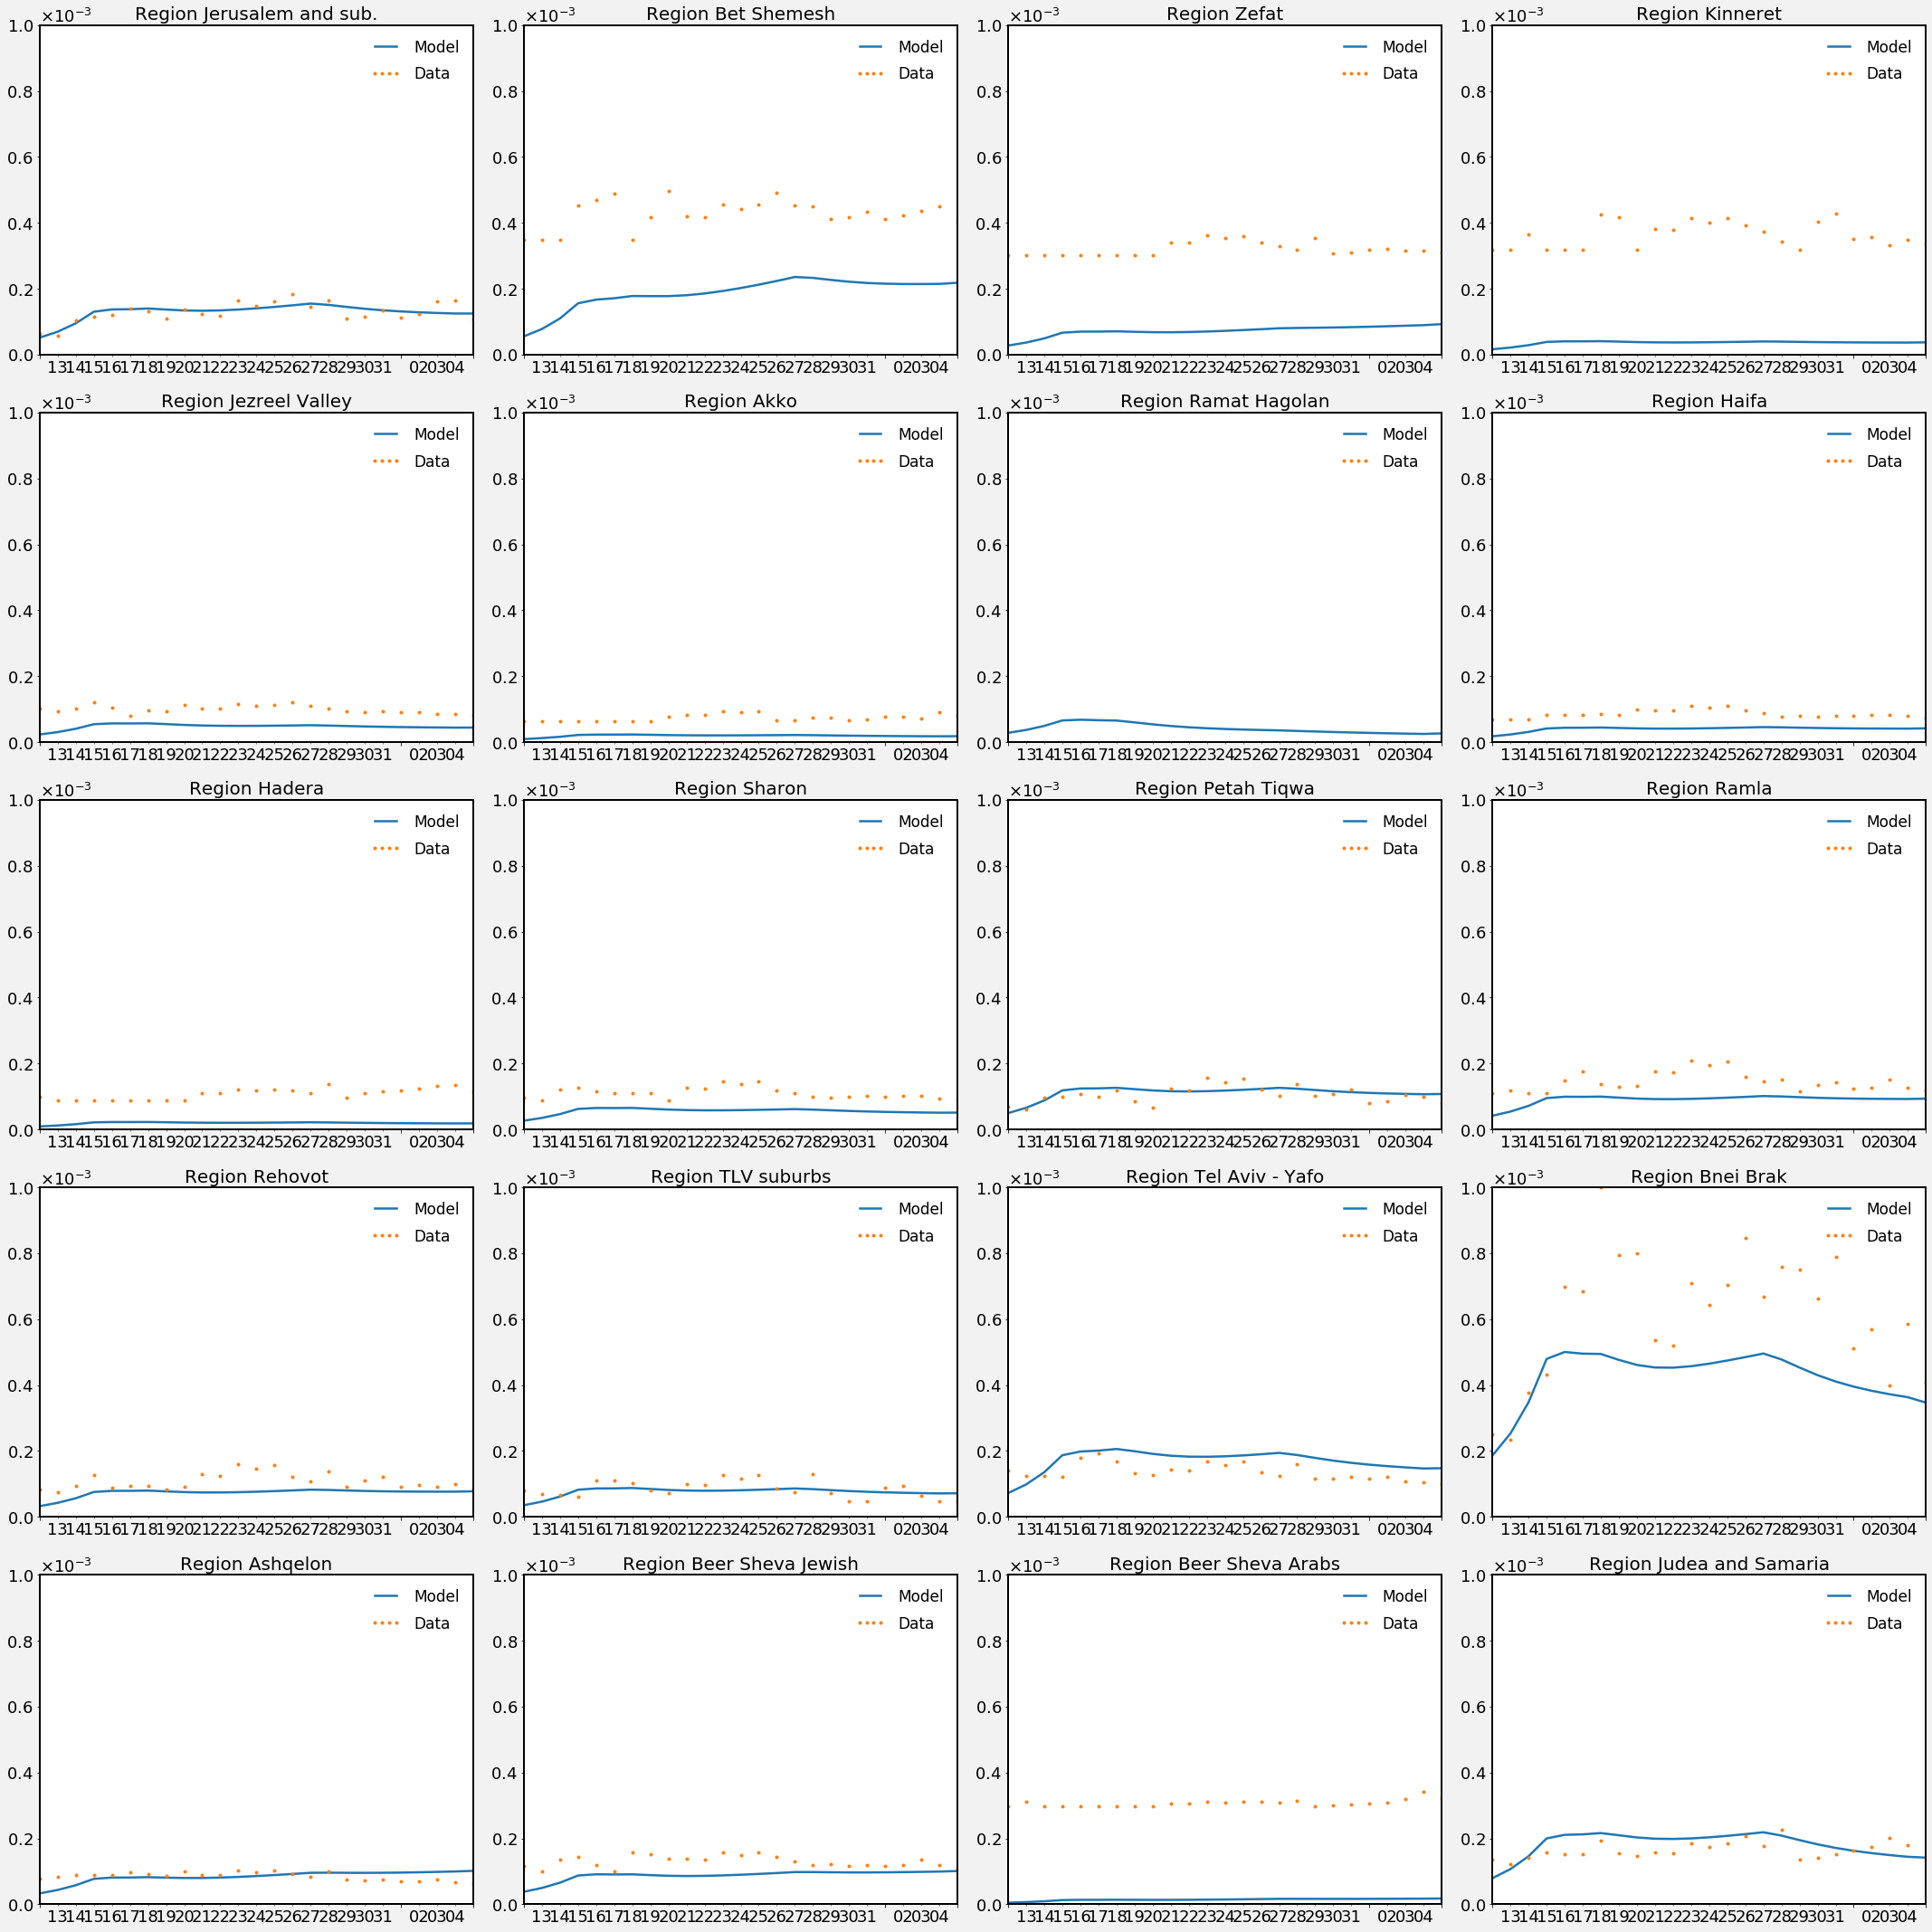

In [33]:
# plotting the data and model
fig,ax = mdl.plot_calibrated_model_region(data=ub_data.values, mdl_data = res_mdl_ub['new_Is'],date_list = date_lst,
                                         start='2020-03-12',end='2020-04-05')
fig.set_size_inches((30,30))
plt.tight_layout()
plt.show()

In [11]:
mdl.plot_calibrated_total_model(data=ub_data, mdl_data=res_mdl_ub, date_list=date_lst, 
                            start='2020-03-12', end='2020-04-05')

NameError: name 'ub_data' is not defined

In [35]:
res_mdl_ub['new_Is'].sum()

0.04792615860434173

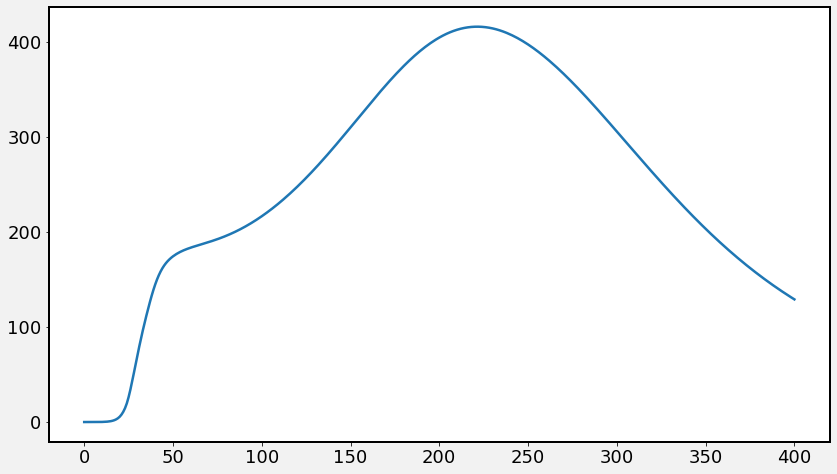

In [6]:
plt.plot((res_mdl_ub['H'].sum(axis=1))*9136000)

### Lower bound

In [47]:
# Calculating data with adding std
lb_data = data*0.5

In [3]:
# fit params
days_in_season_lb=70
alpha_lb=1
date_lst = pd.date_range('2020-02-20','2020-04-13')

In [48]:
# Model Fitting
p0=(0.06862921,0.07089788,0.08567678,0.3,1.5103006972556037, 0.4293725726208387) # initial guess
bnds = ((0,0.1),(0,0.15),(0,0.15),(0,0.6),(1,3),(0,1))# boundries for variables
# errorfunc(tpl,data,f,season_length, eps, alpha)
res_fit_lb= optimize.minimize(mdl.errorfunc_by_sector_behavior,p0,bounds=bnds,method='TNC',args=(lb_data.values,mdl.f0_full['Scenario2'],
                                                                           days_in_season_ub,mdl.eps_sector['Scenario2'],alpha_ub,date_lst,
                                                                                    '2020-03-12-','2020-04-05')
                           ,options={'maxiter':1000})

fitted_params_lb = res_fit_lb.x

# run the fitted model:
fitted_beta_lb = np.array([fitted_params_lb[0], fitted_params_lb[0], fitted_params_lb[0], fitted_params_lb[1], fitted_params_lb[1],\
                        fitted_params_lb[2], fitted_params_lb[2], fitted_params_lb[3], fitted_params_lb[3]])
theta_lb = fitted_params_lb[4]
beta_behave_lb = fitted_params_lb[5]
                        
# print data stat
mdl.print_stat_fit_behave(res_fit_lb)

minimized value: -26.594874666871632
Fitted parameters:
 Beta=[0.01684003 0.03004164 0.03680587 0.11561031]
 Theta=3.0,
 Beta_behave=0.8029761250996457
num of sampling the target function: 426


In [4]:
# best fit results:
beta_j_lb=np.array([0.01684003,0.01684003,0.01684003,0.03004164,0.03004164,0.03680587,0.03680587,0.11561031,0.11561031])
theta_lb=3.0
beta_behave_lb=0.8029761250996457

In [5]:
res_mdl_lb = mdl.run_sector_model_behavior(beta_home=0.38/9., theta=theta_lb, beta_j=beta_j_lb, beta_behave=beta_behave_lb,
                                        eps=mdl.eps_sector['Scenario2'], f=mdl.f0_full['Scenario2'], alpha=alpha_lb, 
                                        days_in_season=175,new=1./10.)

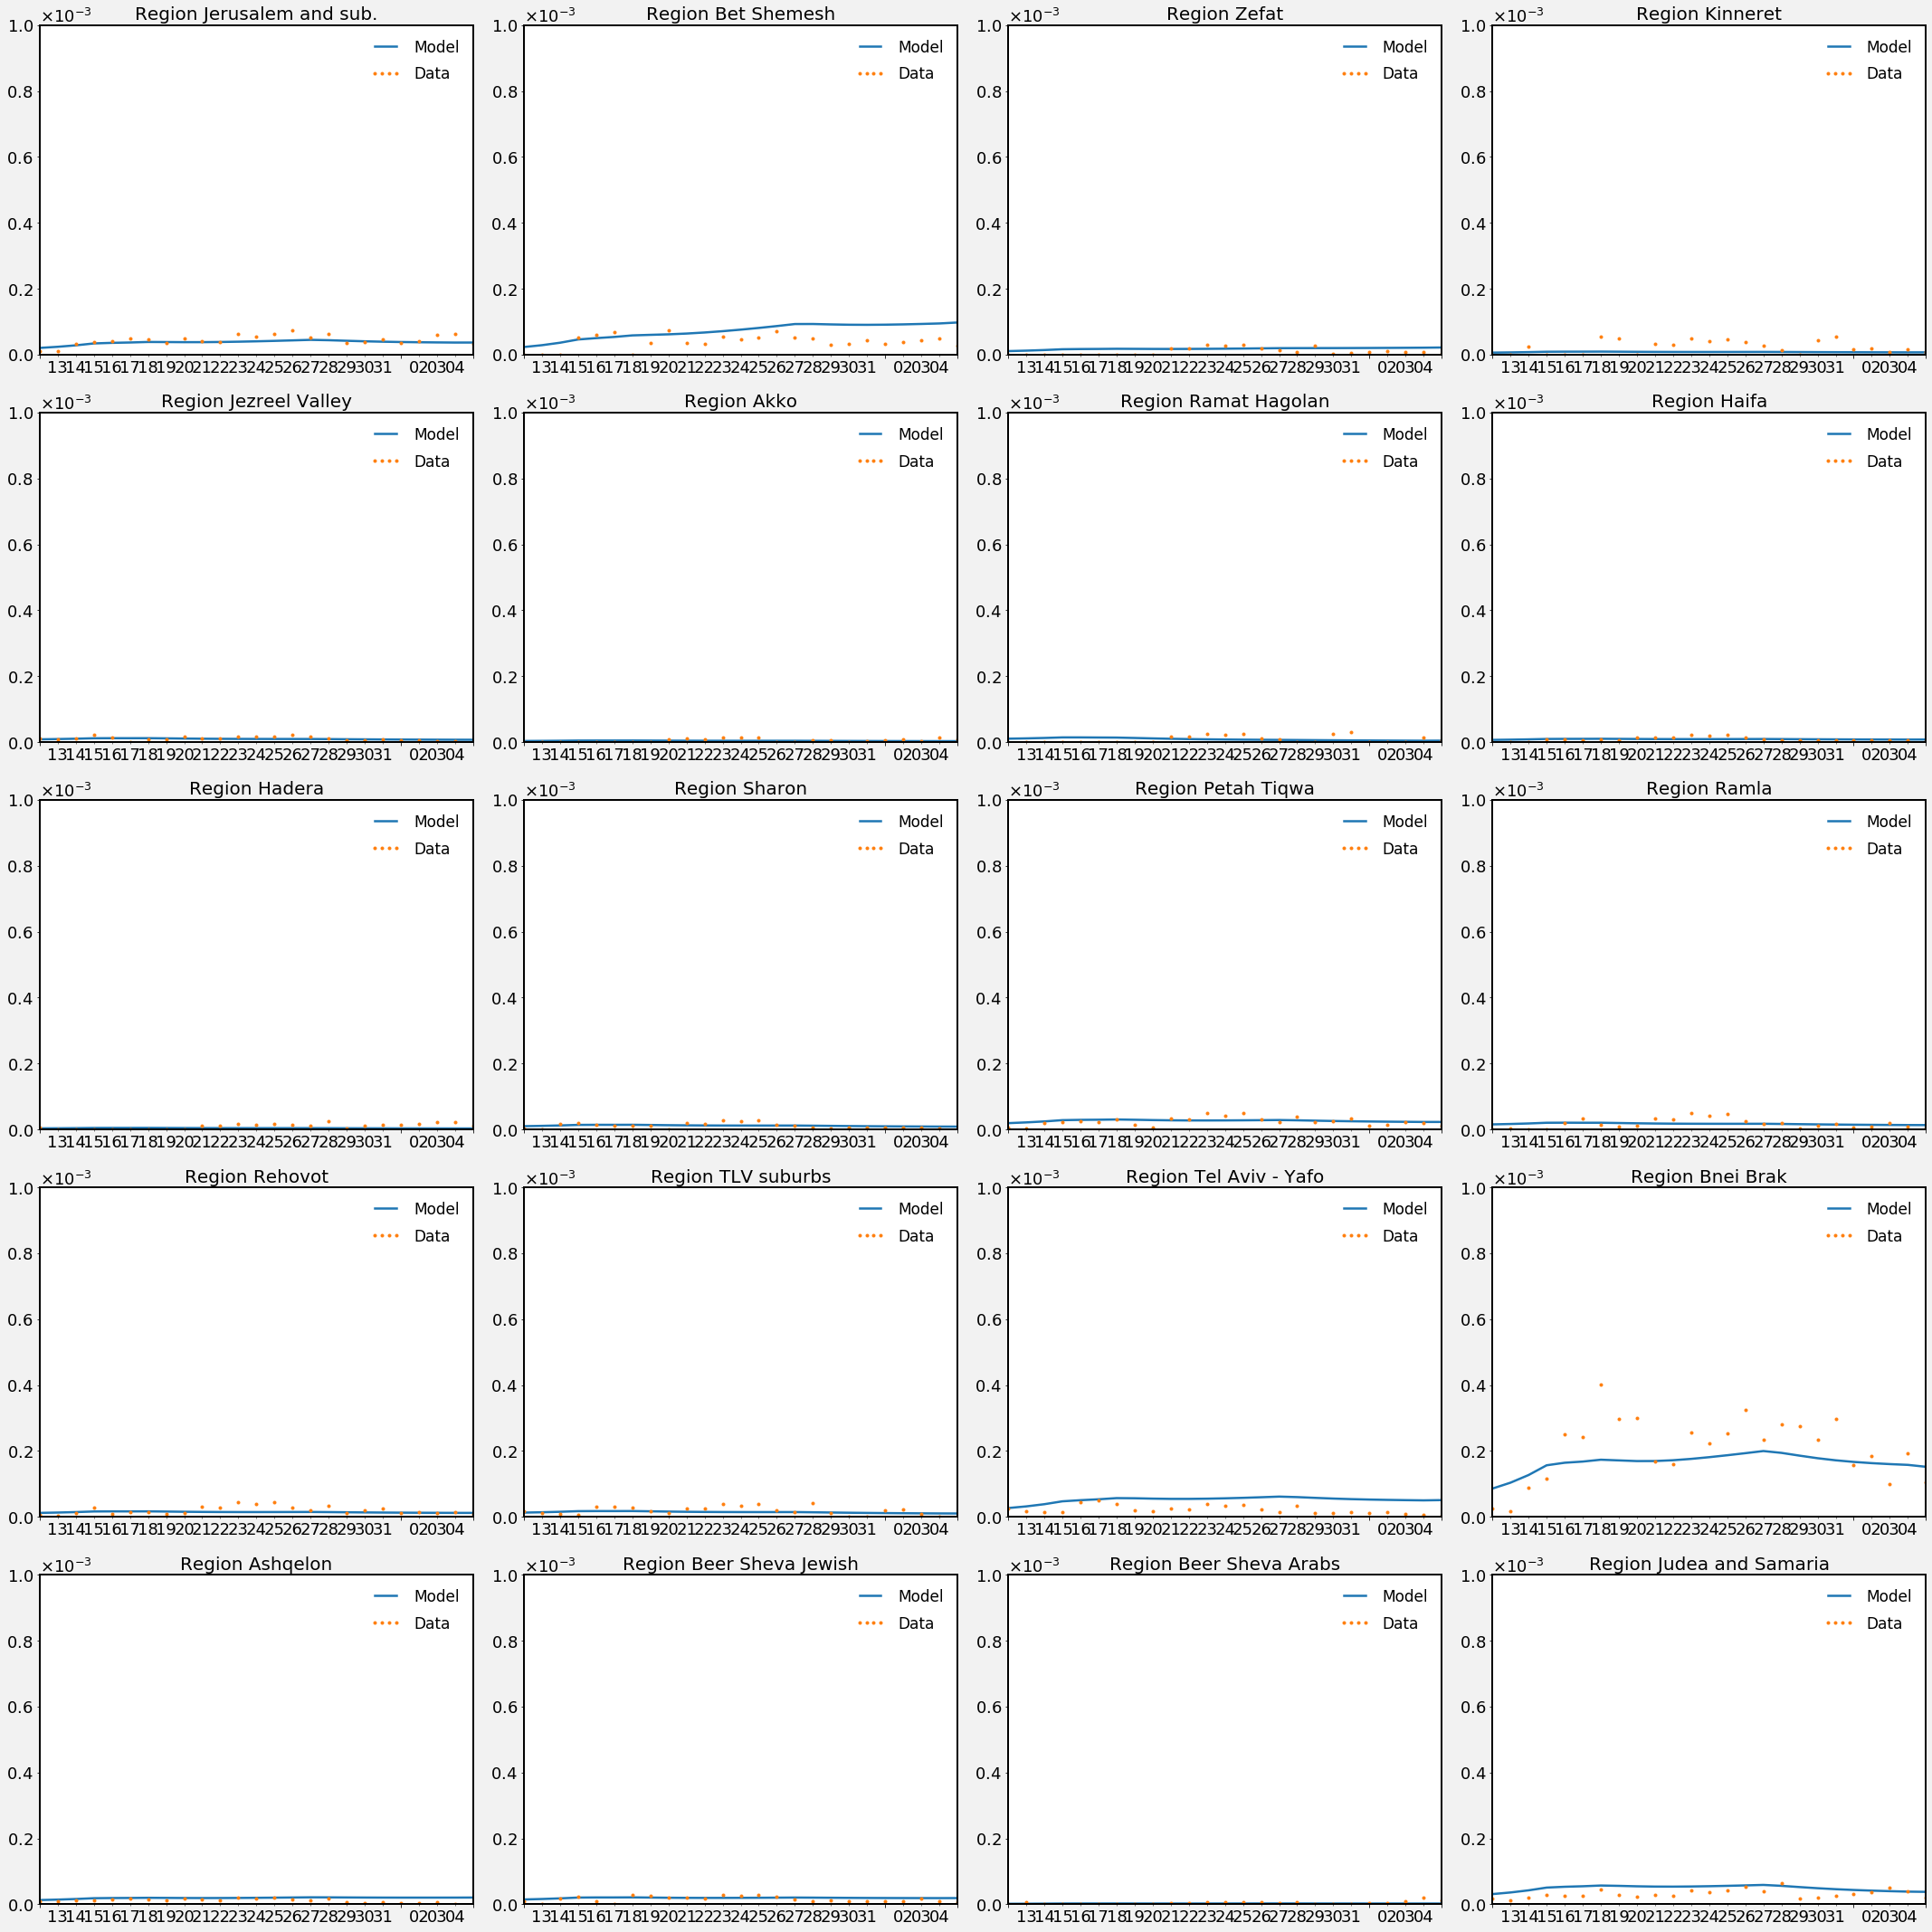

In [50]:
# plotting the data and model
fig,ax = mdl.plot_calibrated_model_region(data=lb_data.values, mdl_data = res_mdl_lb['new_Is'],date_list = date_lst,
                                         start='2020-03-12',end='2020-04-05')
fig.set_size_inches((30,30))
plt.tight_layout()
plt.show()

(<Figure size 1008x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1434be59f28>)

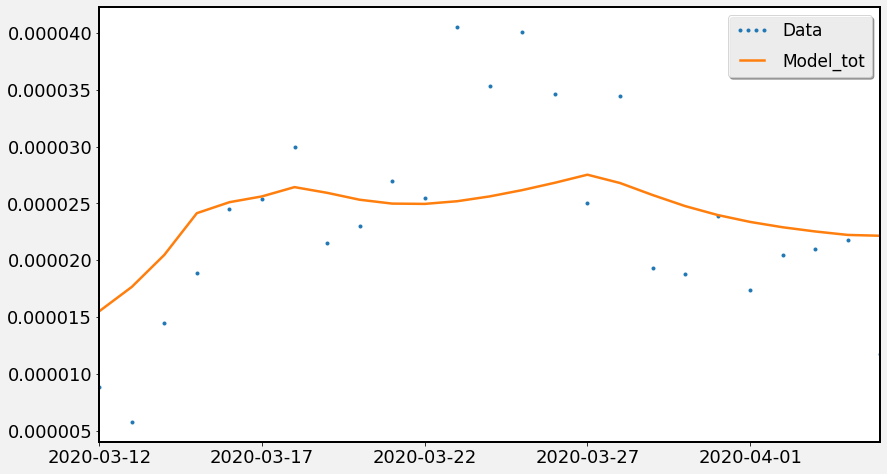

In [51]:
mdl.plot_calibrated_total_model(data=lb_data, mdl_data=res_mdl_lb, date_list=date_lst, 
                            start='2020-03-12', end='2020-04-05')

In [35]:
res_mdl_ub['new_Is'].sum()

0.04792615860434173

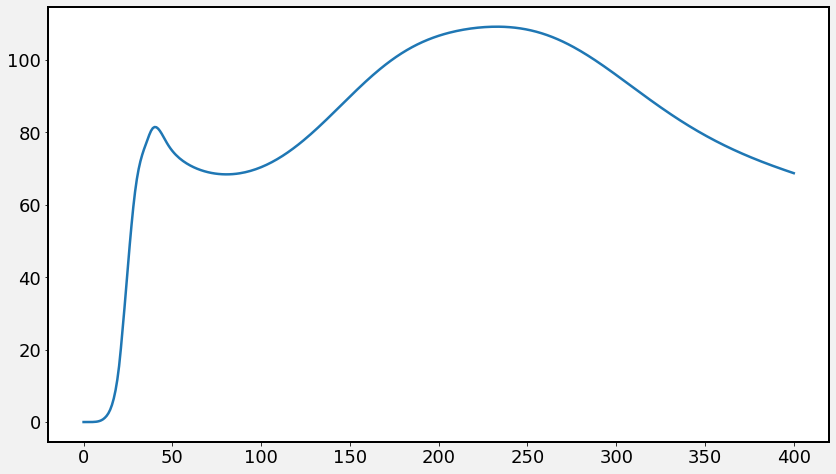

In [16]:
plt.plot((res_mdl_lb['H'].sum(axis=1))*9136000)

# 60+ in Quarantine

In [6]:
inter_age = mdl.get_opposite_dict(mdl.N,list(itertools.product(mdl.M.values(), mdl.A.values())))

In [7]:
inter_age.keys()

dict_keys([('Intervention', '0-4'), ('Intervention', '5-9'), ('Intervention', '10-19'), ('Intervention', '20-29'), ('Intervention', '30-39'), ('Intervention', '40-49'), ('Intervention', '50-59'), ('Intervention', '60-69'), ('Intervention', '70+'), ('Non-intervention', '0-4'), ('Non-intervention', '5-9'), ('Non-intervention', '10-19'), ('Non-intervention', '20-29'), ('Non-intervention', '30-39'), ('Non-intervention', '40-49'), ('Non-intervention', '50-59'), ('Non-intervention', '60-69'), ('Non-intervention', '70+')])

In [7]:
# age_lst = ['0-4']
age_lst = ['0-4','5-9','10-19','20-29','30-39','40-49','50-59']

In [8]:
# new S
init_pop = res_mdl_lb['S'][56,:].copy()
for age in mdl.A.values():
#     if age not in ['60-69','70+']:
    if age  in age_lst:
        init_pop[inter_age['Intervention',age]] = init_pop[inter_age['Non-intervention',age]]
        init_pop[inter_age['Non-intervention',age]] = 0

In [9]:
# new E
init_E = res_mdl_lb['E'][56,:].copy()
for age in mdl.A.values():
#     if age not in ['60-69','70+']:
    if age  in age_lst:
        init_E[inter_age['Intervention',age]] = init_E[inter_age['Non-intervention',age]]
        init_E[inter_age['Non-intervention',age]] = 0

In [10]:
# new Ie
init_Ie = res_mdl_lb['Ie'][56,:].copy()
for age in mdl.A.values():
#     if age not in ['60-69','70+']:
    if age  in age_lst:
        init_Ie[inter_age['Intervention',age]] = init_Ie[inter_age['Non-intervention',age]]
        init_Ie[inter_age['Non-intervention',age]] = 0

In [11]:
#new Is
init_Is = res_mdl_lb['Is'][56,:].copy()
for age in mdl.A.values():
#     if age not in ['60-69','70+']:
    if age  in age_lst:
        init_Is[inter_age['Intervention',age]] = init_Is[inter_age['Non-intervention',age]]
        init_Is[inter_age['Non-intervention',age]] = 0

In [12]:
#new Ia
init_Ia = res_mdl_lb['Ia'][56,:].copy()
for age in mdl.A.values():
#     if age not in ['60-69','70+']:
    if age  in age_lst:
        init_Ia[inter_age['Intervention',age]] = init_Ia[inter_age['Non-intervention',age]]
        init_Ia[inter_age['Non-intervention',age]] = 0

In [13]:
with open('Data/parameters/C_quarantine_60_70.pickle', 'rb') as pickle_in:
    C = pickle.load(pickle_in)

In [14]:
res_mdl_60_70 = mdl.continue_run_sector_model_behavior(model_res=res_mdl_lb,t_start=56,intervention=True,C=C,
                                  beta_home=0.38/9., theta=1.0, beta_j=beta_j_lb, beta_behave=beta_behave_lb,
                                        eps=mdl.eps_sector['Scenario2'], f=mdl.f0_full['Scenario2'], alpha=alpha_lb, 
                                        days_in_season=120, new=1/10., new_pop_dist=init_pop, new_E=init_E, new_I_e=init_Ie,
                                                      new_I_s=init_Is, new_I_a=init_Ia)

In [15]:
res_mdl_60_70['new_Is'].sum()

0.3216035651029858

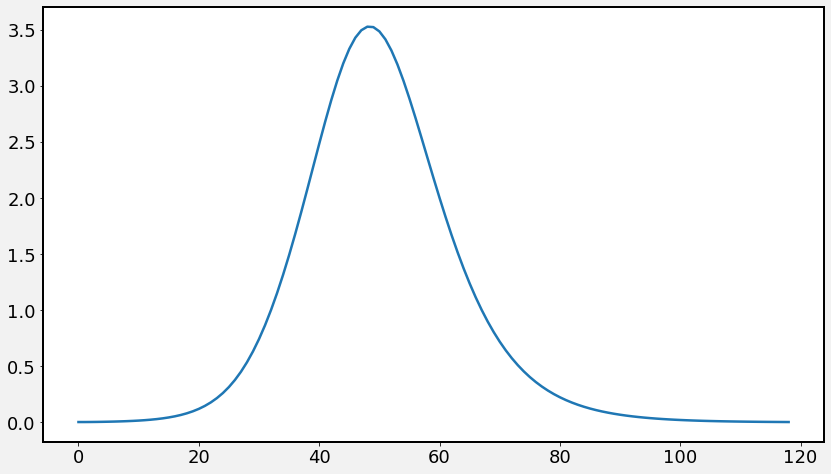

In [24]:
plt.plot(res_mdl_60_70['L'][:,mdl.age_ga_dict['50-59']].sum(axis=1))

In [46]:
res_mdl_60_70['L'][:,mdl.age_ga_dict['70+']].sum(axis=0)

array([2.7822938057688567, 10.090682276505333, 2.3630754192621497,
       2.0758851984796114, 2.022659989724443, 2.1463613489194797,
       1.9562127270101466, 1.0547903837229198, 1.9094703818715446,
       1.480017136347956, 1.6545384143004904, 1.945172818461262,
       1.3708231864985674, 0.9558232479351321, 0.6031561584801624,
       11.05951949352481, 1.678195159857887, 1.618420243526544,
       10.338985332775621, 6.650471081271031], dtype=object)

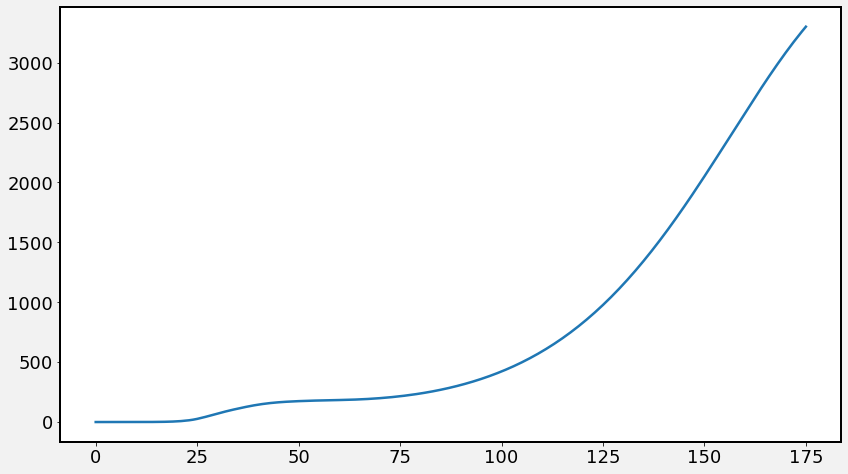

In [15]:
plt.plot((res_mdl_60_70['H'].sum(axis=1)[:])*9136000)

In [16]:
# Save
with open('Data/parameters/low_60_70.pickle', 'wb') as handle:
    pickle.dump(res_mdl_60_70, handle, protocol=pickle.HIGHEST_PROTOCOL)

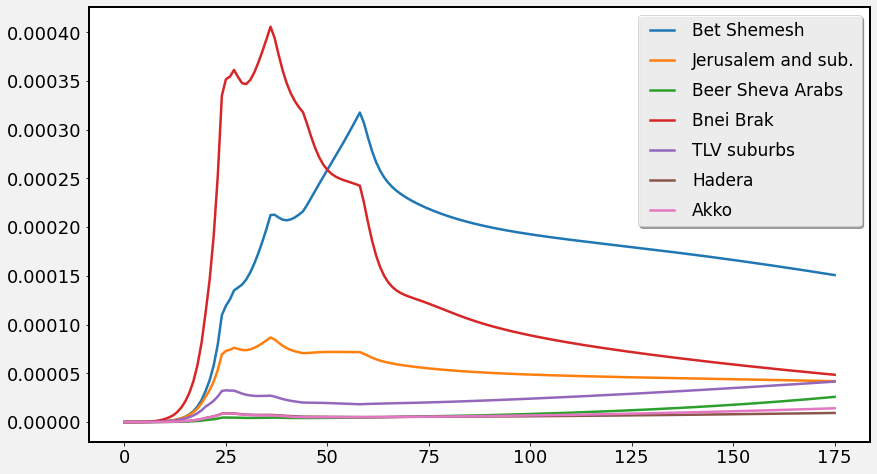

In [18]:
# Creating table 1, by region:
tabel_1_dict = {}
for region in ['11_betshemesh','11','62_arab','51_bb','51','32','24']:
    tabel_1_dict[mdl.region_name[region]] = (res_mdl_60_70['new_Is'][:, mdl.region_dict[region]].sum(axis=1))/mdl.population_size[mdl.region_dict[region]].sum()
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

tabel1_df.iloc[:].plot()

# Data for dashboard

In [27]:
with open('Data/parameters/low_60_70.pickle', 'rb') as pickle_in:
    res_low = pickle.load(pickle_in)

with open('Data/parameters/high_60_70.pickle', 'rb') as pickle_in:
    res_high = pickle.load(pickle_in)
    
with open('Data/parameters/normal_60_70.pickle', 'rb') as pickle_in:
    res_normal = pickle.load(pickle_in)

In [28]:
date_rang = pd.date_range('2020-02-20', periods=176, freq='d')

In [29]:
age_dist_area = pd.read_csv('../Data/demograph/age_dist_area.csv',index_col=0).iloc[0:20][['0-4', '5-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']].copy()
age_dist_area = age_dist_area.sum(axis=1)

In [30]:
tot_I = res_normal['Is'] + res_normal['Ia']
tot_I_ub = res_high['Is'] + res_high['Ia']
tot_I_lb = res_low['Is'] + res_low['Ia']

In [31]:
# tabel 1, coloring the map
# Creating table 1, by region:
tabel_1_dict = {}
tabel_1_dict['date'] = date_rang
for region in mdl.region_dict.keys():
    tabel_1_dict[mdl.region_name[region]] = (tot_I[:, mdl.region_dict[region]].sum(axis=1))/age_dist_area[region]
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

In [32]:
# 'daysoffset' will container the weekday, as integers
tabel1_df['daysoffset'] = tabel1_df['date'].apply(lambda x: x.weekday())
# We apply, row by row (axis=1) a timedelta operation
tabel1_df['week_start'] = tabel1_df.apply(lambda x: x['date'] - dt.timedelta(days=x['daysoffset']), axis=1)

In [33]:
tab1_groupped = tabel1_df.groupby('week_start')[list(mdl.region_name.values())]
tab1_groupped = tab1_groupped.apply(lambda x: (x.max() + x.min())/2)

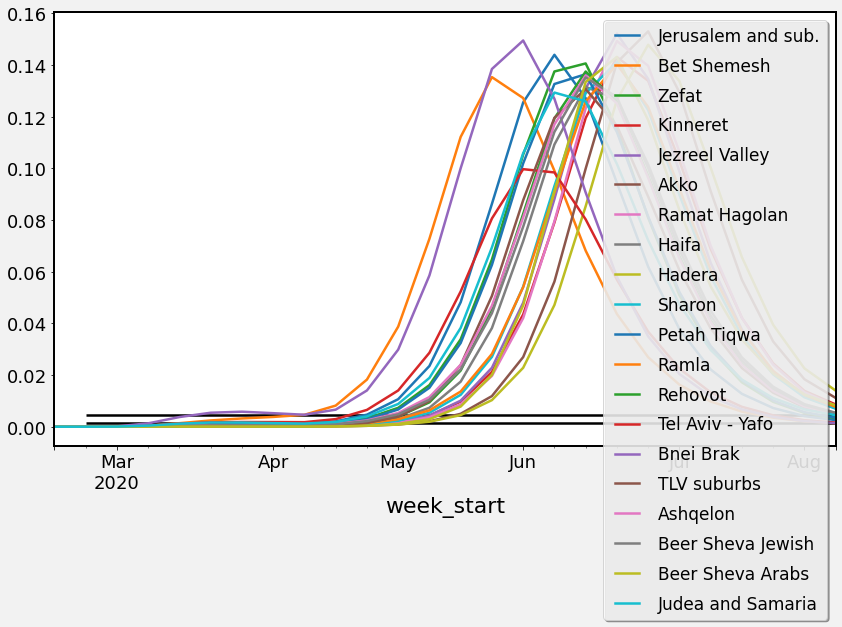

In [34]:
tab1_groupped[list(mdl.region_name.values())].plot()
plt.hlines(xmin='2020-02-20',xmax='2020-09-30', y=0.0045)
plt.hlines(xmin='2020-02-20',xmax='2020-09-30', y=0.0013)

In [35]:
tab1_groupped.loc['2020-04-17':'2020-06-17'].stack()

week_start                    
2020-04-20  Jerusalem and sub.    0.002043
            Bet Shemesh           0.008170
            Zefat                 0.001444
            Kinneret              0.000369
            Jezreel Valley        0.000326
                                    ...   
2020-06-15  TLV suburbs           0.130734
            Ashqelon              0.135986
            Beer Sheva Jewish     0.135187
            Beer Sheva Arabs      0.133438
            Judea and Samaria     0.125941
Length: 180, dtype: float64

In [36]:
# Saving table_1:
tab1_groupped.loc['2020-04-17':'2020-06-17'].stack().to_csv('Incidence_per_region_60_70.csv')

In [35]:
# Age groups

In [37]:
tabel_2 = pd.DataFrame(index = pd.MultiIndex.from_tuples(itertools.product(date_rang, mdl.A.values()),names=['date','age']), 
                                     columns=['mean','UB','LB'])

In [38]:
# fill the matrix:
for index in list(tabel_2.index):
#     print(int(np.where(date_rang == index[0])[0]))
    tabel_2.loc[index,'mean'] = tot_I[int(np.where(date_rang == index[0])[0]),mdl.age_dict[index[1]]].sum()
    tabel_2.loc[index,'UB'] = tot_I_ub[int(np.where(date_rang == index[0])[0]),mdl.age_dict[index[1]]].sum()
    tabel_2.loc[index,'LB'] = tot_I_lb[int(np.where(date_rang == index[0])[0]),mdl.age_dict[index[1]]].sum()

In [39]:
# 'daysoffset' will container the weekday, as integers
tabel_2['daysoffset'] = tabel_2.apply(lambda x: x.name[0].weekday(),axis=1)
# We apply, row by row (axis=1) a timedelta operation
tabel_2['week_start'] = tabel_2.apply(lambda x: x.name[0] - dt.timedelta(days=x['daysoffset']), axis=1)

In [40]:
tabel_2.reset_index(inplace=True)

In [41]:
tabel_2_groupped = tabel_2.groupby(['week_start','age'])[['mean','UB','LB']]
tabel_2_groupped = tabel_2_groupped.apply(lambda x: (x.max() + x.min())/2) * 9136000

In [42]:
tabel_2_groupped['mean'] = tabel_2_groupped['mean'].apply(np.ceil)
tabel_2_groupped['UB'] = tabel_2_groupped['UB'].apply(np.ceil)
tabel_2_groupped['LB'] = tabel_2_groupped['LB'].apply(np.ceil)

In [43]:
tabel_2_groupped.reset_index(inplace=True)

In [44]:
tabel_2_groupped[tabel_2_groupped.week_start == '2020-06-15']

week_start    age      mean        UB        LB
153 2020-06-15    0-4   82171.0  110190.0   71008.0
154 2020-06-15  10-19  182249.0  161255.0  152613.0
155 2020-06-15  20-29  194272.0  129588.0  177209.0
156 2020-06-15  30-39  166215.0  130322.0  149138.0
157 2020-06-15  40-49  164289.0   99583.0  169218.0
158 2020-06-15    5-9   78422.0  100826.0   66487.0
159 2020-06-15  50-59  108290.0   99466.0   89764.0
160 2020-06-15  60-69   94797.0   82382.0   78314.0
161 2020-06-15    70+   49238.0   71124.0   38782.0

In [45]:
tabel_2_groupped[(tabel_2_groupped.week_start>'2020-04-16')&(tabel_2_groupped.week_start<'2020-06-16')].to_csv('bar_plot_model_60_70.csv')

In [ ]:
# ventilators

In [47]:
vents_dict['mean'][55]

133.0

In [46]:
vents_dict = {}
vents_dict['date'] = date_rang
vents_dict['mean'] = np.ceil(res_normal['H'].sum(axis=1) * 9136000)+53
vents_dict['UB'] = np.ceil(res_high['H'].sum(axis=1) * 9136000)+53
vents_dict['LB'] = np.ceil(res_low['H'].sum(axis=1) * 9136000)+53
vents_df = pd.DataFrame.from_dict(vents_dict)

In [48]:
# 'daysoffset' will container the weekday, as integers
vents_df['daysoffset'] = vents_df['date'].apply(lambda x: x.weekday())
# We apply, row by row (axis=1) a timedelta operation
vents_df['week_start'] = vents_df.apply(lambda x: x['date'] - dt.timedelta(days=x['daysoffset']), axis=1)

In [49]:
vents_df_grop = vents_df.groupby('week_start')[['mean','UB','LB']]
vents_df_grop = vents_df_grop.max()

In [51]:
vents_df_grop['2020-04-16':'2020-06-16'].to_csv('ventilators_60_70.csv')